In [ ]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
from fastai.vision.all import *
from fastai.vision.gan import *
from functools import partial
import math
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from pathlib import Path
import PIL
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torch.nn.utils.spectral_norm import SpectralNorm
from torchvision.models.vgg import vgg19
from typing import Callable, List, Tuple, Type

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = 64
n_channels = 3
bs = 64

# Data

## Input ds

## Target ds

In [ ]:
# celeba_path = Path('./img_align_celeba')
celeba_path = Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba')
#target_fns = get_image_files(celeba_path)
# get_image_files is too slow, there's no need to check the extension here
target_fns = celeba_path.ls()
target_fns

---

In [ ]:
normalize_tf = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5]))
normalize_imagenet_tf = Normalize.from_stats(*imagenet_stats)

dblock = DataBlock(blocks=(TransformBlock, ImageBlock),
                   get_x=generate_noise,
                   #get_items=get_image_files,
                   get_items=lambda path: target_fns,
                   splitter=IndexSplitter([]),
                   item_tfms=Resize(img_size, method=ResizeMethod.Crop), 
                   batch_tfms=normalize_tf)
#main_path = anime_faces_path
main_path = celeba_path
dls = dblock.dataloaders(main_path, path=main_path, bs=bs)

In [ ]:
dls.show_batch()

# Loss function

## Gradient penalty

In [ ]:
class GANGPCallback(Callback):
    def __init__(self, plambda=10., epsilon_sampler=None, center_val=1): 
        self.plambda = plambda
        if epsilon_sampler is None: epsilon_sampler = random_epsilon_gp_sampler
        self.epsilon_sampler = epsilon_sampler
        self.center_val = center_val
        
    def _gradient_penalty(self, real, fake, plambda, epsilon_sampler):
        epsilon = epsilon_sampler(real, fake)
        x_hat = (epsilon * real + (1 - epsilon) * fake).requires_grad_(True)
        x_hat_pred = self.model.critic(x_hat).mean()

        grads = torch.autograd.grad(outputs=x_hat_pred, inputs=x_hat, create_graph=True)[0]
        return plambda * ((grads.norm() - self.center_val)**2)    
        
    def after_loss(self):
        if not self.gan_trainer.gen_mode:
            # In critic mode, GANTrainer swaps x and y; so, here x is original y (real target)
            real = self.x
            assert not self.y.requires_grad
            # Cast to TensorImage to enable product compatibility
            fake = TensorImage(self.model.generator(self.y))
            # Updated to fastai version 2.2.7: backward isn't called on learn.loss anymore, 
            # but on learn.loss_grad
            self.learn.loss_grad += self._gradient_penalty(real, fake, self.plambda, self.epsilon_sampler)


def random_epsilon_gp_sampler(real: torch.Tensor, fake: torch.Tensor) -> torch.Tensor:
    # A different random value of epsilon for any element of a batch
    epsilon_vec = torch.rand(real.shape[0], 1, 1, 1, dtype=torch.float, device=real.device, requires_grad=False)
    return epsilon_vec.expand_as(real)

            
class R1GANGPCallback(Callback):
    def __init__(self, weight=10.): 
        self.weight = weight
        
    def _gradient_penalty(self, real, weight):
        x = real.detach().requires_grad_(True)
        preds = self.model.critic(x).mean()

        grads = torch.autograd.grad(outputs=preds, inputs=x, create_graph=True)[0]
        #return weight * (grads.norm()**2)  
        # (flat+dot product) seems more efficient than norm**2
        flat_grads = grads.view(-1)
        return weight * flat_grads.dot(flat_grads)
        
    def after_loss(self):
        if not self.gan_trainer.gen_mode:
            # In critic mode, GANTrainer swaps x and y; so, here x is original y (real target)
            real = self.x
            # Updated to fastai version 2.2.7: backward isn't called on learn.loss anymore, 
            # but on learn.loss_grad
            self.learn.loss_grad += self._gradient_penalty(real, self.weight)


def repelling_reg_term(ftr_map, weight):
    bs = ftr_map.shape[0]
    flat_ftrs = ftr_map.view(bs, -1)
    norms = flat_ftrs.norm(dim=1).unsqueeze(1)
    # Cosine similarity between ftrs of any batch
    # cos_sims[i, j] = cosine similarity between ftrs of batch `i` and ftrs of batch `j`
    cos_sims = torch.mm(flat_ftrs, flat_ftrs.t()) / torch.mm(norms, norms.t())
    # Substract bs to discard the diagonal, which is full of 1's
    return weight * (cos_sims.square().sum() - bs) / (bs * (bs - 1))


class RepellingRegCallback(Callback):
    "Increases the G loss every iteration with a repelling regularization term."
    def __init__(self, module, weight=1.):
        self.hook = hook_output(module, detach=False)
        self.weight = weight
        self.history = []
    
    def after_loss(self):
        if not self.training: return
        if self.gan_trainer.gen_mode:
            ftr_map = self.hook.stored
            assert ftr_map.requires_grad
            reg_term = repelling_reg_term(ftr_map, self.weight)
            self.history.append(reg_term.detach().cpu())
            self.learn.loss_grad += reg_term

# Architecture

In [ ]:
def drop_bns(m):
    idxs_to_drop = []
    for i, child in enumerate(m.children()):
        if isinstance(child, nn.BatchNorm2d):
            idxs_to_drop.append(i)
        else:
            drop_bns(child)
    for idx in idxs_to_drop: m[idx] = nn.Identity()
        
def replace_encoder_bn(m, affine=True):
    idxs_to_replace = []
    for i, child in enumerate(m.children()):
        if isinstance(child, UnetBlock): break
        if isinstance(child, nn.BatchNorm2d):
            idxs_to_replace.append(i)
        else:
            replace_encoder_bn(child, affine)
    for idx in idxs_to_replace: 
        m[idx] = InstanceNorm(m[idx].num_features, affine=affine)
        
def replace_decoder_bn(unet):
    for l in unet.layers:
        if isinstance(l, UnetBlock):
            l.bn = InstanceNorm(l.bn.num_features, affine=True)    
        
def replace_unet_bn(unet):
    replace_encoder_bn(unet)
    replace_decoder_bn(unet)
        
def drop_decoder_bn(unet):
    for l in unet.layers:
        if isinstance(l, UnetBlock):
            l.bn = nn.Identity()
            
def add_sn(m):
    idxs_to_edit = []
    for i, l in enumerate(m.children()):
        if isinstance(l, nn.Conv2d) or isinstance(l, nn.ConvTranspose2d):
            idxs_to_edit.append(i)
        add_sn(l)
    for i in idxs_to_edit:
        m[i] = spectral_norm(m[i])
        
        
def set_act_inplace(m:nn.Module, act_cls=nn.ReLU, act_cls_set=nn.ReLU):
    if isinstance(m, nn.Sequential) or isinstance(m, nn.ModuleList):
        idxs_to_modify = []
        for i in range(len(m)):
            if isinstance(m[i], act_cls):
                idxs_to_modify.append(i)
            elif len(list(m[i].children())) > 0:
                set_act_inplace(m[i], act_cls, act_cls_set)
        for i in idxs_to_modify:
            m[i] = act_cls_set(inplace=True)        
    elif len(list(m.children())) > 0:
        for attr_name in dir(m):
            attr_value = getattr(m, attr_name)
            if isinstance(attr_value, act_cls):
                setattr(m, attr_name, act_cls_set(inplace=True))
            elif isinstance(attr_value, nn.Module) and (len(list(attr_value.children())) > 0):
                set_act_inplace(attr_value, act_cls, act_cls_set)

In [ ]:
conv_types = [nn.Conv1d, nn.Conv2d, nn.Conv3d,
              nn.ConvTranspose1d, nn.ConvTranspose2d, nn.ConvTranspose3d]

def is_conv(m:nn.Module):
    return any(isinstance(m, conv_type) for conv_type in conv_types)

def has_sn_hook(m:nn.Module):
    return any(isinstance(h, SpectralNorm) 
               for h in m._forward_pre_hooks.values())

def every_conv_has_sn(module:nn.Module):
    for m in module.modules():
        if is_conv(m) and not has_sn_hook(m):
            return False
    return True

def is_iterable(x):
    try:
        iterator = iter(x)
    except TypeError:
        return False
    else:
        return True
    
def get_mean_weights(m, layer_types):
    all_modules_dict = dict(m.named_modules())
    result = {}
    for param_name, param in m.named_parameters():
        module = all_modules_dict[param_name.rsplit('.', 1)[0]]
        if isinstance(module, layer_types):
            result[param_name] = param.data.abs().mean()
    return result

In [ ]:
from abc import ABC, abstractmethod


class MiniResBlock(nn.Module):
    def __init__(self, in_ftrs, out_ftrs, norm_type=None, act_cls=nn.ReLU, **conv_kwargs):
        super().__init__()
        norm_type = (NormType.BatchZero if norm_type==NormType.Batch else
                     NormType.InstanceZero if norm_type==NormType.Instance 
                     else norm_type)
        self.convpath = ConvLayer(in_ftrs, out_ftrs, norm_type=norm_type, act_cls=act_cls,
                                  **conv_kwargs)
        self.act = act_cls()
        
    def forward(self, x): return self.act(self.convpath(x) + x)


class ConcatPool2d(Module):
    "Layer that concats `AvgPool2d` and `MaxPool2d`"
    def __init__(self, ks, stride=None, padding=0):
        self.ap = nn.AvgPool2d(ks, stride, padding)
        self.mp = nn.MaxPool2d(ks, stride, padding)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)


class ConditionalBatchNorm2d(nn.Module):
    """BN layer whose gain (gamma) and bias (beta) params also depend on an external condition vector."""
    def __init__(self, n_ftrs:int, cond_sz:int, gain_init:Callable=None, bias_init:Callable=None):
        super().__init__()
        self.n_ftrs = n_ftrs
        # Don't learn beta and gamma inside self.bn (fix to irrelevance: beta=1, gamma=0)
        self.bn = nn.BatchNorm2d(n_ftrs, affine=False)
        self.gain = nn.Linear(cond_sz, n_ftrs, bias=False)
        self.bias = nn.Linear(cond_sz, n_ftrs, bias=False)        
        if gain_init is None: gain_init = nn.init.zeros_
        if bias_init is None: bias_init = nn.init.zeros_
        init_default(self.gain, gain_init)
        init_default(self.bias, bias_init)

    def forward(self, x, cond):
        out = self.bn(x)
        gamma = 1 + self.gain(cond)
        beta = self.bias(cond)
        out = gamma.view(-1, self.n_ftrs, 1, 1) * out + beta.view(-1, self.n_ftrs, 1, 1)
        return out


class MiniBatchStdDev(nn.Module):
    def __init__(self, group_sz=4, unbiased_std=False):
        super().__init__()
        self.group_sz = group_sz
        self.unbiased_std = unbiased_std
        self.history_mean = [] # TODO: delete this?
        self.history_std = [] # TODO: delete this?

    def forward(self, x):
        bs, n_ch, h, w = x.shape
        # We assume bs is divisible by self.group_sz
        x_groups = x.view(-1, self.group_sz, n_ch, h, w)
        stds_by_chw = x_groups.std(dim=1, unbiased=self.unbiased_std)
        mean_std = stds_by_chw.mean(dim=[1, 2, 3], keepdim=True)
        if isinstance(mean_std, InvisibleTensor):
            self.history_mean.append(mean_std.mean().item())
            self.history_std.append(mean_std.std().item())
        new_ftr_map = mean_std.unsqueeze(-1).repeat(1, self.group_sz, 1, h, w).view(bs, 1, h, w)
        return torch.cat([x, new_ftr_map], axis=1)
    

class CondConvLayer(nn.Module):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and conditional `norm_type` layers."
    @delegates(nn.Conv2d)
    def __init__(self, ni, nf, cond_sz, ks=3, stride=1, padding=None, bias=None, ndim=2, 
                 norm_type=NormType.Batch, bn_1st=True, act_cls=defaults.activation, 
                 transpose=False, init='auto', xtra=None, xtra_begin=None, bias_std=0.01, 
                 **kwargs):
        super().__init__()
        if padding is None: padding = ((ks-1)//2 if not transpose else 0)
        bn = norm_type in (NormType.Batch, NormType.BatchZero)
        inn = norm_type in (NormType.Instance, NormType.InstanceZero)
        if bias is None: bias = not (bn or inn)
        conv_func = nn.ConvTranspose2d if transpose else nn.Conv2d
        conv = conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding, **kwargs)
        act = None if act_cls is None else act_cls()
        init_linear(conv, act, init=init, bias_std=bias_std)
        if   norm_type==NormType.Weight:   conv = weight_norm(conv)
        elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
        self.layers = nn.ModuleList([conv])
        act_bn = []
        if act is not None: act_bn.append(act)
        if bn: act_bn.append(ConditionalBatchNorm2d(nf, cond_sz))
        # TODO: implement Conditional/AdaptiveInstanceNorm
        if inn: act_bn.append(InstanceNorm(nf, norm_type=norm_type, ndim=ndim))
        if bn_1st: act_bn.reverse()
        self.layers += act_bn
        if xtra_begin: self.layers.insert(0, xtra_begin)
        if xtra: self.layers.append(xtra)
    
    def forward(self, x, cond):
        for l in self.layers:
            if isinstance(l, ConditionalBatchNorm2d):
                x = l(x, cond)
            else:
                x = l(x)
        return x

    
class DownsamplingOperation2d(ABC):
    @abstractmethod
    def get_layer(self, in_ftrs:int=None, out_ftrs:int=None, **op_kwargs) -> nn.Module:
        "Must return a layer that increases the size of the last 2d of the input"
        pass

    
class AvgPoolHalfDownsamplingOp2d(DownsamplingOperation2d):
    def __init__(self, conv_ks=3, act_cls=None, norm_type=None):
        self.conv_ks = conv_ks
        self.act_cls = act_cls
        self.norm_type = norm_type

    def get_layer(self, in_ftrs:int=None, out_ftrs:int=None, **op_kwargs) -> nn.Module:
        layers = [nn.AvgPool2d(2)]
        if out_ftrs != in_ftrs:
            layers.append(ConvLayer(in_ftrs, out_ftrs, ks=self.conv_ks, act_cls=self.act_cls,
                                    norm_type=self.norm_type, **op_kwargs))
        return nn.Sequential(*layers)

    
class ConcatPoolHalfDownsamplingOp2d(DownsamplingOperation2d):
    def __init__(self, conv_ks=3, act_cls=None, norm_type=None, always_add_conv=False):
        self.conv_ks = conv_ks
        self.act_cls = act_cls
        self.norm_type = norm_type
        self.always_add_conv = always_add_conv

    def get_layer(self, in_ftrs:int=None, out_ftrs:int=None, **op_kwargs) -> nn.Module:
        layers = [ConcatPool2d(2)]
        if (out_ftrs != (in_ftrs*2)) or self.always_add_conv:
            layers.append(ConvLayer(in_ftrs*2, out_ftrs, ks=self.conv_ks, act_cls=self.act_cls,
                                    norm_type=self.norm_type, **op_kwargs))
        return nn.Sequential(*layers)
    

class ConvHalfDownsamplingOp2d(DownsamplingOperation2d):
    def __init__(self, ks=4, padding=1, act_cls:Type[nn.Module]=None, norm_type=None,
                 bn_1st=True):
        self.ks=ks
        self.act_cls = act_cls
        self.padding = padding
        self.norm_type = norm_type
        self.bn_1st = bn_1st

    def get_layer(self, in_ftrs:int=None, out_ftrs:int=None, **op_kwargs) -> nn.Module:
        assert (in_ftrs is not None) and (out_ftrs is not None), \
            "in_ftrs and out_ftrs must both be valued for this UpsamplingOperation"
        if 'act_cls' not in op_kwargs:
            op_kwargs['act_cls'] = self.act_cls
        if 'norm_type' not in op_kwargs:
            op_kwargs['norm_type'] = self.norm_type
        if 'padding' not in op_kwargs:
            op_kwargs['padding'] = self.padding
#         conv = ConvLayer(in_ftrs, out_ftrs, self.ks, 2, bias=False, bn_1st=self.bn_1st,
#                          **op_kwargs)
        conv = ConvLayer(in_ftrs, out_ftrs, self.ks, 2, bn_1st=self.bn_1st,
                         **op_kwargs)
        return conv


class UpsamplingOperation2d(ABC):
    @abstractmethod
    def get_layer(self, in_ftrs:int=None, out_ftrs:int=None, **op_kwargs) -> nn.Module:
        "Must return a layer that increases the size of the last 2d of the input"
        pass

    
class PixelShuffleUpsamplingOp2d(UpsamplingOperation2d):
    def __init__(self, scale_factor=2, blur=False, n_extra_convs=0, act_cls:Type[nn.Module]=None, norm_type=None):
        self.scale_factor = scale_factor
        self.blur = blur
        self.n_extra_convs = n_extra_convs
        self.act_cls = act_cls
        self.norm_type = norm_type
    
    def get_layer(self, in_ftrs:int=None, out_ftrs:int=None, **op_kwargs):
        if 'act_cls' not in op_kwargs:
            op_kwargs['act_cls'] = self.act_cls
        if 'blur' not in op_kwargs:
            op_kwargs['blur'] = self.blur
        if 'norm_type' not in op_kwargs:
            op_kwargs['norm_type'] = self.norm_type
        layer = PixelShuffle_ICNR(in_ftrs, out_ftrs, self.scale_factor, **op_kwargs)
        if self.n_extra_convs > 0:
            extra_convs = [ConvLayer(out_ftrs, out_ftrs, norm_type=self.norm_type)
                           for _ in range(self.n_extra_convs)]
            layer = nn.Sequential(layer, *extra_convs)
        return layer

    
class InterpConvUpsamplingOp2d(UpsamplingOperation2d):
    def __init__(self, scale_factor=2, mode='nearest', ks=3, act_cls:Type[nn.Module]=None,
                 norm_type=NormType.Batch, bn_1st=True):
        self.scale_factor = scale_factor
        self.mode = mode
        self.act_cls = act_cls
        self.ks = ks
        self.norm_type = norm_type
        self.bn_1st = bn_1st

    def get_layer(self, in_ftrs:int=None, out_ftrs:int=None, **op_kwargs) -> nn.Module:
        if 'act_cls' not in op_kwargs:
            op_kwargs['act_cls'] = self.act_cls
        if 'norm_type' not in op_kwargs:
            op_kwargs['norm_type'] = self.norm_type
        return nn.Sequential(nn.Upsample(scale_factor=self.scale_factor, mode=self.mode),
                             ConvLayer(in_ftrs, out_ftrs, self.ks, bn_1st=self.bn_1st, 
                                       **op_kwargs))


class CondInterpConvUpsamplingOp2d(UpsamplingOperation2d):
    def __init__(self, cond_sz, scale_factor=2, mode='nearest', ks=3, act_cls:Type[nn.Module]=None,
                 norm_type=NormType.Batch, bn_1st=True):
        self.cond_sz = cond_sz
        self.scale_factor = scale_factor
        self.mode = mode
        self.act_cls = act_cls
        self.ks = ks
        self.norm_type = norm_type
        self.bn_1st = bn_1st

    def get_layer(self, in_ftrs:int=None, out_ftrs:int=None, **op_kwargs) -> nn.Module:
        if 'act_cls' not in op_kwargs:
            op_kwargs['act_cls'] = self.act_cls
        if 'norm_type' not in op_kwargs:
            op_kwargs['norm_type'] = self.norm_type
        upsample = nn.Upsample(scale_factor=self.scale_factor, mode=self.mode)
        return CondConvLayer(in_ftrs, out_ftrs, self.cond_sz, self.ks, bn_1st=self.bn_1st, 
                             xtra_begin=upsample, **op_kwargs)


class ConvX2UpsamplingOp2d(UpsamplingOperation2d):
    def __init__(self, ks=4, act_cls:Type[nn.Module]=None, padding=1, output_padding=0,
                 norm_type=NormType.Batch, bn_1st=True):
        #self.apply_sn = apply_sn
        self.ks=ks
        self.act_cls = act_cls
        self.padding = padding
        self.output_padding = output_padding
        self.norm_type = norm_type
        self.bn_1st=bn_1st

    def get_layer(self, in_ftrs:int=None, out_ftrs:int=None, **op_kwargs) -> nn.Module:
        assert (in_ftrs is not None) and (out_ftrs is not None), \
            "in_ftrs and out_ftrs must both be valued for this UpsamplingOperation"
        if 'act_cls' not in op_kwargs:
            op_kwargs['act_cls'] = self.act_cls
        if 'norm_type' not in op_kwargs:
            op_kwargs['norm_type'] = self.norm_type
        conv = ConvLayer(in_ftrs, out_ftrs, self.ks, 2, self.padding, transpose=True, 
                         bias=False, output_padding=self.output_padding, bn_1st=self.bn_1st,
                         **op_kwargs)
#         if self.apply_sn and (op_kwargs.get('norm_type') != NormType.Spectral): 
#             add_sn(conv)
        return conv


class CondConvX2UpsamplingOp2d(UpsamplingOperation2d):
    def __init__(self, cond_sz, ks=4, act_cls:Type[nn.Module]=None, padding=1, output_padding=0,
                 norm_type=NormType.Batch, bn_1st=True):
        self.cond_sz = cond_sz
        self.ks=ks
        self.act_cls = act_cls
        self.padding = padding
        self.output_padding = output_padding
        self.norm_type = norm_type
        self.bn_1st=bn_1st

    def get_layer(self, in_ftrs:int=None, out_ftrs:int=None, **op_kwargs) -> nn.Module:
        assert (in_ftrs is not None) and (out_ftrs is not None), \
            "in_ftrs and out_ftrs must both be valued for this UpsamplingOperation"
        if 'act_cls' not in op_kwargs:
            op_kwargs['act_cls'] = self.act_cls
        if 'norm_type' not in op_kwargs:
            op_kwargs['norm_type'] = self.norm_type
        conv = CondConvLayer(in_ftrs, out_ftrs, self.cond_sz, self.ks, 2, self.padding, 
                             transpose=True, bias=False, output_padding=self.output_padding, 
                             bn_1st=self.bn_1st, **op_kwargs)
        return conv


def custom_generator(out_size, n_channels, up_op:UpsamplingOperation2d, in_sz=100, 
                     n_features=64, n_extra_layers=0, sn=True, **kwargs):
    "A basic generator from `in_sz` to images `n_channels` x `out_size` x `out_size`."
    cur_size, cur_ftrs = 4, n_features//2
    while cur_size < out_size:  cur_size *= 2; cur_ftrs *= 2
    layers = [AddChannels(2), ConvLayer(in_sz, cur_ftrs, 4, 1, transpose=True, **kwargs)]
    cur_size = 4
    while cur_size < out_size // 2:
        layers.append(up_op.get_layer(cur_ftrs, cur_ftrs//2, **kwargs))
        cur_ftrs //= 2; cur_size *= 2
    layers += [ConvLayer(cur_ftrs, cur_ftrs, 3, 1, 1, transpose=True, **kwargs) for _ in range(n_extra_layers)]
    layers += [up_op.get_layer(cur_ftrs, n_channels, norm_type=None, act_cls=None), nn.Tanh()]
    generator = nn.Sequential(*layers)
    if sn: add_sn(generator)
    return generator

In [ ]:
class ResBlockUp(nn.Module):
    def __init__(self, in_ftrs, out_ftrs, up_op:UpsamplingOperation2d, 
                 id_up_op:UpsamplingOperation2d, n_extra_convs=1, 
                 upsample_first=True, norm_type=NormType.Batch, 
                 act_cls=nn.ReLU, bn_1st=True, **up_op_kwargs):
        super().__init__()
        
#         norm2 = (NormType.BatchZero if norm_type==NormType.Batch else
#                  NormType.InstanceZero if norm_type==NormType.Instance 
#                  else norm_type)
        up_layer = up_op.get_layer(in_ftrs, out_ftrs, **up_op_kwargs)
        extra_convs_ftrs = out_ftrs if upsample_first else in_ftrs
        inner_path_ls = ([ConvLayer(extra_convs_ftrs, extra_convs_ftrs, bn_1st=bn_1st, norm_type=norm_type,
                                    #norm_type=norm_type if ((i<n_extra_convs-1) or not upsample_first) else norm2,
                                    act_cls=act_cls if ((i<n_extra_convs-1) or (not upsample_first) or (not bn_1st)) else None)
                         for i in range(n_extra_convs)])
        inner_path_ls.insert(0 if upsample_first else len(inner_path_ls),
                            up_layer)
        self.inner_path = nn.Sequential(*inner_path_ls)
        
        self.id_path = id_up_op.get_layer(in_ftrs, out_ftrs)
        
        self.act = defaults.activation(inplace=True) if act_cls is None else act_cls()
        
    def forward(self, x): return self.act(self.inner_path(x) + self.id_path(x))
    

class RescaledResBlockUp(ResBlockUp):
    def forward(self, x): return self.act((self.inner_path(x) + self.id_path(x)) / 2)
    

class DenseBlockUp(ResBlockUp):
    def __init__(self, in_ftrs, out_ftrs, up_op:UpsamplingOperation2d, 
                 id_up_op:UpsamplingOperation2d, n_extra_convs=1, 
                 upsample_first=True, norm_type=NormType.Batch, 
                 act_cls=nn.ReLU, bn_1st=True, **up_op_kwargs):
        super().__init__(in_ftrs, out_ftrs, up_op, id_up_op, n_extra_convs=n_extra_convs, 
                         upsample_first=upsample_first, norm_type=norm_type, 
                         act_cls=act_cls, bn_1st=bn_1st, **up_op_kwargs)
        
        self.final_conv = ConvLayer(out_ftrs*2, out_ftrs, bn_1st=bn_1st, norm_type=norm_type,
                                    act_cls=act_cls)       
        
    def forward(self, x): 
        return self.final_conv(self.act(torch.cat([self.inner_path(x), self.id_path(x)], axis=1)))


class CondResBlockUp(nn.Module):
    def __init__(self, in_ftrs, out_ftrs, cond_sz, up_op:UpsamplingOperation2d, 
                 id_up_op:UpsamplingOperation2d, n_extra_convs=1, 
                 upsample_first=True, norm_type=NormType.Batch, 
                 act_cls=nn.ReLU, bn_1st=True, **up_op_kwargs):
        super().__init__()
        
        up_layer = up_op.get_layer(in_ftrs, out_ftrs, **up_op_kwargs)
        extra_convs_ftrs = out_ftrs if upsample_first else in_ftrs
        inner_path_ls = ([CondConvLayer(extra_convs_ftrs, extra_convs_ftrs, cond_sz, bn_1st=bn_1st, norm_type=norm_type,
                                    act_cls=act_cls if ((i<n_extra_convs-1) or (not upsample_first) or (not bn_1st)) else None)
                         for i in range(n_extra_convs)])
        inner_path_ls.insert(0 if upsample_first else len(inner_path_ls),
                            up_layer)
        self.inner_path = nn.ModuleList(inner_path_ls)
        
        self.id_path = id_up_op.get_layer(in_ftrs, out_ftrs)
        
        self.act = defaults.activation(inplace=True) if act_cls is None else act_cls()
        
    def forward(self, x, cond): 
        inner_out = x
        for l in self.inner_path:
            inner_out = l(inner_out, cond)
        return self.act(inner_out + self.id_path(x, cond))


class ResBlockDown(nn.Module):
    def __init__(self, in_ftrs, out_ftrs, down_op:DownsamplingOperation2d, 
                 id_down_op:DownsamplingOperation2d, n_extra_convs=1,
                 downsample_first=False, norm_type=NormType.Batch, 
                 act_cls=partial(nn.LeakyReLU, negative_slope=0.2),
                 bn_1st=True, **down_op_kwargs):
        super().__init__()
        
#         norm2 = (NormType.BatchZero if norm_type==NormType.Batch else
#                  NormType.InstanceZero if norm_type==NormType.Instance 
#                  else norm_type)
        down_layer = down_op.get_layer(in_ftrs, out_ftrs, **down_op_kwargs)
        extra_convs_ftrs = out_ftrs if downsample_first else in_ftrs
        inner_path_ls = ([ConvLayer(extra_convs_ftrs, extra_convs_ftrs, bn_1st=bn_1st, norm_type=norm_type,
                                    #norm_type=norm_type if ((i<n_extra_convs-1) or not downsample_first) else norm2,
                                    act_cls=act_cls if ((i<n_extra_convs-1) or (not downsample_first) or (not bn_1st)) else None)
                         for i in range(n_extra_convs)])
        inner_path_ls.insert(0 if downsample_first else len(inner_path_ls),
                            down_layer)
        self.inner_path = nn.Sequential(*inner_path_ls)
        
        self.id_path = id_down_op.get_layer(in_ftrs, out_ftrs, bias=False)
        
        self.act = defaults.activation(inplace=True) if act_cls is None else act_cls()
        
    def forward(self, x): return self.act(self.inner_path(x) + self.id_path(x))
    

class RescaledResBlockDown(ResBlockDown):
    def forward(self, x): return self.act((self.inner_path(x) + self.id_path(x)) / 2)
    
    
class PseudoDenseBlockDown(ResBlockDown):
    def __init__(self, in_ftrs, out_ftrs, down_op:DownsamplingOperation2d, 
                 id_down_op:DownsamplingOperation2d, n_extra_convs=1,
                 downsample_first=False, norm_type=NormType.Batch, 
                 act_cls=partial(nn.LeakyReLU, negative_slope=0.2),
                 bn_1st=True, **down_op_kwargs):
        super().__init__(in_ftrs, out_ftrs//2, down_op, id_down_op, n_extra_convs=n_extra_convs,
                         downsample_first=downsample_first, norm_type=norm_type, 
                         act_cls=act_cls, bn_1st=bn_1st, **down_op_kwargs)      
        
    def forward(self, x): 
        return self.act(torch.cat([self.inner_path(x), self.id_path(x)], axis=1)) 
    
    
class DenseBlockDown(ResBlockDown):
    def __init__(self, in_ftrs, out_ftrs, down_op:DownsamplingOperation2d, 
                 id_down_op:DownsamplingOperation2d, n_extra_convs=1,
                 downsample_first=False, norm_type=NormType.Batch, 
                 act_cls=partial(nn.LeakyReLU, negative_slope=0.2),
                 bn_1st=True, **down_op_kwargs):
        super().__init__(in_ftrs, out_ftrs, down_op, id_down_op, n_extra_convs=n_extra_convs,
                         downsample_first=downsample_first, norm_type=norm_type, 
                         act_cls=act_cls, bn_1st=bn_1st, **down_op_kwargs)
        
        self.final_conv = ConvLayer(out_ftrs*2, out_ftrs, bn_1st=bn_1st, norm_type=norm_type,
                                    act_cls=act_cls)
        
    def forward(self, x): 
        return self.final_conv(self.act(torch.cat([self.inner_path(x), self.id_path(x)], axis=1)))


def res_generator(out_sz, n_ch, up_op:UpsamplingOperation2d, id_up_op:UpsamplingOperation2d,
                  in_sz=100, n_features=64, n_extra_res_blocks=1, n_extra_convs_by_res_block=1,
                  sn=True, bn_1st=True, upblock_cls=ResBlockUp, **kwargs):
    cur_sz, cur_ftrs = 4, n_features//2
    while cur_sz < out_sz:  cur_sz *= 2; cur_ftrs *= 2
    layers = [AddChannels(2), 
              ConvLayer(in_sz, cur_ftrs, 4, 1, transpose=True, bn_1st=bn_1st, **kwargs)]
    cur_sz = 4
    while cur_sz < out_sz // 2:
        layers.append(upblock_cls(cur_ftrs, cur_ftrs//2, up_op, id_up_op, 
                                  n_extra_convs=n_extra_convs_by_res_block,
                                  bn_1st=bn_1st, **kwargs))
        cur_ftrs //= 2; cur_sz *= 2
    layers += [ResBlock(1, cur_ftrs, cur_ftrs, bn_1st=bn_1st, **kwargs) 
               for _ in range(n_extra_res_blocks)]
    layers += [up_op.get_layer(cur_ftrs, n_ch, norm_type=None, act_cls=None), nn.Tanh()]
    generator = nn.Sequential(*layers)
    if sn: add_sn(generator)
    return generator


class NoiseSplitStrategy(ABC):    
    @abstractmethod
    def calc_cond_sz(self, noise_sz, n_splits):
        pass
    
    @abstractmethod
    def split_noise(self, noise, n_splits):
        pass


class NoiseSplitEqualLeave1stOutStrategy(NoiseSplitStrategy):     
    def calc_cond_sz(self, noise_sz, n_splits):
        # Divide by `n_splits+1` to next leave first chunk out of conditions
        return noise_sz // (n_splits + 1)
        
    def split_noise(self, noise, n_splits):
        noise_sz = noise.shape[1]
        cond_sz = self.calc_cond_sz(noise_sz, n_splits)
        return noise.split(cond_sz, 1)[1:]
    
    
class NoiseSplitDontSplitStrategy(NoiseSplitStrategy):
    def calc_cond_sz(self, noise_sz, n_splits):
        return noise_sz
        
    def split_noise(self, noise, n_splits):
        return [noise] * n_splits


class CondResGenerator(nn.Module):
    init_sz = 4
    
    def __init__(self, out_sz, n_ch, up_op:UpsamplingOperation2d, id_up_op:UpsamplingOperation2d, 
                 noise_split_strategy, in_sz=100, n_features=64, n_extra_res_blocks=1, 
                 n_extra_convs_by_res_block=1, sn=True, bn_1st=True, upblock_cls=CondResBlockUp,
                 **kwargs):
        super().__init__()
        self.noise_split_strategy = noise_split_strategy
        cur_sz, cur_ftrs = self.init_sz, n_features//2
        while cur_sz < out_sz:  cur_sz *= 2; cur_ftrs *= 2
        self.initial_layers = nn.Sequential(
            AddChannels(2), 
            ConvLayer(in_sz, cur_ftrs, 4, 1, transpose=True, bn_1st=bn_1st, **kwargs))
        cur_sz = self.init_sz
        n_splits = self.calc_n_upblocks(out_sz)
        self.cond_sz = noise_split_strategy.calc_cond_sz(in_sz, n_splits)
        self.up_layers = nn.ModuleList([])
        while cur_sz < out_sz // 2:
            self.up_layers.append(upblock_cls(cur_ftrs, cur_ftrs//2, self.cond_sz, 
                                              up_op, id_up_op, bn_1st=bn_1st, 
                                              n_extra_convs=n_extra_convs_by_res_block,
                                              **kwargs))
            cur_ftrs //= 2; cur_sz *= 2
            
        self.extra_blocks = nn.Sequential(
            *[ResBlock(1, cur_ftrs, cur_ftrs, bn_1st=bn_1st, **kwargs) 
              for _ in range(n_extra_res_blocks)])
        self.final_conv = up_op.get_layer(cur_ftrs, n_ch, norm_type=None, act_cls=None)
        self.act = nn.Tanh()
        if sn: 
            add_sn(self.initial_layers)
            for up_l in self.up_layers: add_sn(up_l)
            add_sn(self.extra_blocks)
            add_sn(self.final_conv)
    
    @classmethod
    def calc_n_upblocks(cls, out_sz):
        return int(math.log2(out_sz // (2 * cls.init_sz)))
    
    def forward(self, z):
        n_splits = len(self.up_layers)
        z_splits = self.noise_split_strategy.split_noise(z, n_splits)
        x = self.initial_layers(z)
        for zi, up_layer in zip(z_splits, self.up_layers):
            x = up_layer(x, zi)
        x = self.extra_blocks(x)
        return self.act(self.final_conv(x, None))

    
class SkipGenerator(nn.Module):
    def __init__(self, out_sz, n_ch, up_op:UpsamplingOperation2d, id_up_op:UpsamplingOperation2d,
                 in_sz=100, n_features=64, n_extra_res_blocks=1, n_extra_convs_by_res_block=1,
                 sn=True, bn_1st=True, upblock_cls=ResBlockUp, upsample_skips_mode='nearest',
                 skip2rgb_ks=3, skip_act_cls=nn.Tanh, **kwargs):
        super().__init__()
        cur_sz, cur_ftrs = 4, n_features//2
        while cur_sz < out_sz:  cur_sz *= 2; cur_ftrs *= 2
        self.initial_layers = nn.Sequential(
            AddChannels(2), 
            ConvLayer(in_sz, cur_ftrs, 4, 1, transpose=True, bn_1st=bn_1st, **kwargs))
        cur_sz = 4
        self.up_layers = nn.ModuleList([])
        self.skips_torgb = nn.ModuleList([])
        self.upsample_skips_mode = upsample_skips_mode
        while cur_sz < out_sz // 2:
            self.up_layers.append(upblock_cls(cur_ftrs, cur_ftrs//2, up_op, id_up_op, 
                                              n_extra_convs=n_extra_convs_by_res_block,
                                              bn_1st=bn_1st, **kwargs))
            self.skips_torgb.append(ConvLayer(cur_ftrs//2, n_ch, ks=skip2rgb_ks, norm_type=None,
                                              act_cls=skip_act_cls, bias=False))
            cur_ftrs //= 2; cur_sz *= 2
        self.extra_blocks = nn.Sequential(
            *[ResBlock(1, cur_ftrs, cur_ftrs, bn_1st=bn_1st, **kwargs) 
              for _ in range(n_extra_res_blocks)])
        self.last_up = up_op.get_layer(cur_ftrs, n_ch, norm_type=None, act_cls=None)
        self.act = nn.Tanh()
        if sn: 
            add_sn(nn.Sequential(self.initial_layers, self.up_layers, self.skips_torgb,
                                 self.extra_blocks, self.last_up))
    
    def forward(self, x):
        x = self.initial_layers(x)
        out = None
        for up_layer, skip_torgb in zip(self.up_layers, self.skips_torgb):
            x = up_layer(x)
            skip_x = skip_torgb(x)
            out = skip_x if out is None else out + skip_x
            out = F.interpolate(out, scale_factor=2, mode=self.upsample_skips_mode)
        x = self.extra_blocks(x)
        x = self.last_up(x)
        return self.act(out + x)
    

def res_critic(in_size, n_channels, down_op, id_down_op, n_features=64, n_extra_res_blocks=1, 
               norm_type=NormType.Batch, n_extra_convs_by_res_block=0, sn=True, bn_1st=True,
               downblock_cls=ResBlockDown, flatten_full=False, include_minibatch_std=False,
               **kwargs):
    "A basic critic for images `n_channels` x `in_size` x `in_size`."
    layers = [down_op.get_layer(n_channels, n_features, norm_type=None, **kwargs)]
    cur_size, cur_ftrs = in_size//2, n_features
    layers += [ResBlock(1, cur_ftrs, cur_ftrs, norm_type=norm_type, bn_1st=bn_1st, **kwargs) 
               for _ in range(n_extra_res_blocks)]
    while cur_size > 4:
        layers.append(downblock_cls(cur_ftrs, cur_ftrs*2, down_op, id_down_op,
                                    n_extra_convs=n_extra_convs_by_res_block,
                                    norm_type=norm_type, bn_1st=bn_1st, **kwargs))
        cur_ftrs *= 2 ; cur_size //= 2
    init = kwargs.get('init', nn.init.kaiming_normal_)
    if include_minibatch_std: 
        # this may not make much sense when using BN
        layers.append(MiniBatchStdDev())
        cur_ftrs += 1
    #layers += [init_default(nn.Conv2d(cur_ftrs, 1, 4, padding=0, bias=False), init), Flatten()]    
    layers += [init_default(nn.Conv2d(cur_ftrs, 1, 4, padding=0), init), Flatten(full=flatten_full)]
    critic =  nn.Sequential(*layers)
    if sn: add_sn(critic)
    return critic

In [ ]:
critic = basic_critic(img_size, n_channels, n_features=64, n_extra_layers=1)
generator = basic_generator(img_size, n_channels, in_sz=100, n_features=64, 
                            n_extra_layers=1)
add_sn(critic)
add_sn(generator)

In [ ]:
critic, generator

------------------

# Training

In [ ]:
class EMAAverager():
    def __init__(self, decay=0.999):
        self.decay = decay
        
    def __call__(self, averaged_model_parameter, model_parameter, num_averaged):
        return self.decay * averaged_model_parameter + (1 - self.decay) * model_parameter
    

class EMACallback(Callback):
    def __init__(self, ema_model, orig_model, dl, update_buffers=True): 
        self.ema_model = ema_model
        self.orig_model = orig_model
        self.dl = dl
        self.update_buffers = update_buffers
        self.update_bn_pending = False
        
    def after_step(self):
        if self.gan_trainer.gen_mode:
            update_method = (self.ema_model.update_all if self.update_buffers
                             else self.ema_model.update_parameters)
            update_method(self.orig_model)
            self.update_bn_pending = True
            
    def after_fit(self):
        if not self.update_bn_pending: return
        torch.optim.swa_utils.update_bn(self.dl, self.ema_model)
        self.update_bn_pending = False


class FullyAveragedModel(torch.optim.swa_utils.AveragedModel):
    def _update_buffers(self, model):
        for b_swa, b_model in zip(self.module.buffers(), model.buffers()):
            device = b_swa.device
            b_model_ = b_model.detach().to(device)
            if self.n_averaged == 0:
                b_swa.detach().copy_(b_model_)
            else:
                b_swa.detach().copy_(self.avg_fn(b_swa.detach(), b_model_,
                                                 self.n_averaged.to(device)))                

    def update_all(self, model):
        # Buffers must be updated first, because this method relies on n_averaged,
        # which is updated by super().update_parameters()
        self._update_buffers(model)
        self.update_parameters(model)

        
def add_ema_to_gan_learner(gan_learner, dblock, ds_path, decay=0.999, update_bn_dl_bs=64):
    generator = gan_learner.model.generator
    ema_avg_fn = EMAAverager(decay=decay)
    gan_learner.ema_model = FullyAveragedModel(generator, avg_fn=ema_avg_fn)
    clean_dls = dblock.dataloaders(ds_path, path=ds_path, bs=update_bn_dl_bs)
    gan_learner.ema_model.eval().to(clean_dls.device)
    gan_learner.add_cb(EMACallback(gan_learner.ema_model, generator, clean_dls.train))

In [ ]:
def custom_save_model(learner, filename, base_path='/kaggle/working'):
    if isinstance(base_path, str): base_path = Path(base_path)
    if not isinstance(base_path, Path): raise Exception('Invalid base_path')
    file = join_path_file(filename, base_path/learner.model_dir, ext='.pth')
    save_model(file, learner.model, learner.opt)
    if getattr(learn, 'ema_model', None) is not None:
        _save_ema_model(learner, base_path, filename)
    # TODO: delete this
    if getattr(learn, 'ema_extra_model', None) is not None:
        save_ema_extra_model(learner, base_path, filename)
    

def custom_load_model(learner, filename, with_opt=True, device=None, 
                      base_path='/kaggle/input/new-face2anime-weights', 
                      with_ema=False, **kwargs):
    if isinstance(base_path, str): base_path = Path(base_path)
    if not isinstance(base_path, Path): raise Exception('Invalid base_path')
    if device is None and hasattr(learner.dls, 'device'): device = learner.dls.device
    if learner.opt is None: learner.create_opt()
    #file = join_path_file(filename, base_path/learner.model_dir, ext='.pth')
    file = base_path/f'{filename}.pth'
    load_model(file, learner.model, learner.opt, with_opt=with_opt, device=device, **kwargs)
    if with_ema:
        _load_ema_model(learner, base_path, filename)
        # TODO: DELETE this
        load_ema_extra_model_delete_me(learner, base_path, filename)

    
def _load_ema_model(learner, base_path, filename, device=None):
    ema_filename = base_path/f'{filename}_ema.pth'
    load_model(ema_filename, learner.ema_model, None, with_opt=False, device=device)
    #state_dict = torch.load(ema_filename)
    #learner.ema_model.load_state_dict(state_dict)


# TODO: delete this
def load_ema_extra_model_delete_me(learner, base_path, filename, device=None):
    ema_filename = base_path/f'{filename}_ema_extra.pth'
    load_model(ema_filename, learner.ema_extra_model, None, with_opt=False, device=device)
    #state_dict = torch.load(ema_filename)
    #learner.ema_model.load_state_dict(state_dict)    
    

def _save_ema_model(learner, base_path, filename):
    file = join_path_file(filename+'_ema', base_path/learner.model_dir, ext='.pth')
    save_model(file, learner.ema_model, None, with_opt=False)
    #torch.save(file, learner.ema_model.state_dict())

    
# TODO: delete this
def save_ema_extra_model(learner, base_path, filename):
    file = join_path_file(filename+'_ema_extra', base_path/learner.model_dir, ext='.pth')
    save_model(file, learner.ema_extra_model, None, with_opt=False)
    #torch.save(file, learner.ema_model.state_dict())
    

class SaveCheckpointsCallback(Callback):
    "Callback that saves the model at the end of each epoch."
    def __init__(self, learn, fn_prefix, base_path=Path('.'), initial_epoch=1):
        self.fn_prefix = fn_prefix
        self.base_path = base_path
        self.epoch = initial_epoch
        
    def after_epoch(self):
        fn = f'{self.fn_prefix}_{self.epoch}ep'
        custom_save_model(learn, fn, base_path=self.base_path)
        self.epoch += 1
        

def predict_n(learner, n_imgs, max_bs=64):
    dummy_path = Path('')
    dl = learner.dls.test_dl([dummy_path]*n_imgs, bs=max_bs)   
    inp, imgs_t, _, dec_imgs_t = learner.get_preds(dl=dl, with_input=True, with_decoded=True)
    dec_batch = dls.decode_batch((inp,) + tuplify(dec_imgs_t), max_n=n_imgs)
    return dec_batch
    
def predict_show_n(learner, n_imgs, **predict_n_kwargs):
    preds_batch = predict_n(learner, n_imgs, **predict_n_kwargs)
    _, axs = plt.subplots(n_imgs, 2, figsize=(6, n_imgs * 3))
    for i, (inp, pred_img) in enumerate(preds_batch):
        inp.show(ax=axs[i][0])
        pred_img.show(ax=axs[i][1])

## TR 1: WGAN-GP lambda=10, basic G and C, SN+BN in G and C, 5 C/G iters

In [ ]:
def create_learner_1(for_inference=False):
    critic = basic_critic(img_size, n_channels, n_features=64, n_extra_layers=1)
    generator = basic_generator(img_size, n_channels, in_sz=100, n_features=64, 
                                n_extra_layers=1)
    add_sn(critic)
    add_sn(generator)

    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs)
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_1()

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr1_10ep', base_path='.')
learn.show_results(ds_idx=0)

---

Show results after returning to work:

In [ ]:
learn = create_learner_1(for_inference=True)
custom_load_model(learn, 'noise2img_tr1_10ep', with_opt=False)
predict_show_n(learn, 5)

## TR 2: WGAN-GP lambda=0.1, basic G and C, SN+BN in G and C, 5 C/G iters

In [ ]:
def create_learner_2(for_inference=False):
    critic = basic_critic(img_size, n_channels, n_features=64, n_extra_layers=1)
    generator = basic_generator(img_size, n_channels, in_sz=100, n_features=64, 
                                n_extra_layers=1)
    add_sn(critic)
    add_sn(generator)

    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=0.1))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs)
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_2()

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr2_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 3: WGAN-GP lambda=10, basic G and C, SN+BN in G and C, 5 C/G iters, leaky as C act

In [ ]:
def create_learner_3(for_inference=False):
    critic = basic_critic(img_size, n_channels, n_features=64, n_extra_layers=1,
                          act_cls=nn.modules.activation.LeakyReLU)
    generator = basic_generator(img_size, n_channels, in_sz=100, n_features=64, 
                                n_extra_layers=1)
    add_sn(critic)
    add_sn(generator)

    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs)
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_3()

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr3_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 4: WGAN-GP lambda=100, basic G and C, SN+BN in G and C, 5 C/G iters, leaky as C act

In [ ]:
def create_learner_4(for_inference=False):
    critic = basic_critic(img_size, n_channels, n_features=64, n_extra_layers=1,
                          act_cls=nn.modules.activation.LeakyReLU)
    generator = basic_generator(img_size, n_channels, in_sz=100, n_features=64, 
                                n_extra_layers=1)
    add_sn(critic)
    add_sn(generator)

    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=100.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs)
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_4()

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr4_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 5: WGAN-GP lambda=10, basic G and C, SN+BN in G and C, 1 C/G iters, leaky as C act

In [ ]:
def create_learner_5(for_inference=False):
    critic = basic_critic(img_size, n_channels, n_features=64, n_extra_layers=1,
                          act_cls=nn.modules.activation.LeakyReLU)
    generator = basic_generator(img_size, n_channels, in_sz=100, n_features=64, 
                                n_extra_layers=1)
    add_sn(critic)
    add_sn(generator)

    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher = FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_5()

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr5_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn = create_learner_5()
custom_load_model(learn, 'noise2img_tr5_8ep', base_path='./models')

In [ ]:
learn.fit(2, 5e-5)
custom_save_model(learn, 'noise2img_tr5_10ep_low_lr', base_path='.')
learn.show_results(ds_idx=0)

## TR 6: WGAN-GP lambda=10, basic G and C, SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with interp+conv

In [ ]:
def create_learner_6(for_inference=False):
    critic = basic_critic(img_size, n_channels, n_features=64, n_extra_layers=1,
                          act_cls=nn.modules.activation.LeakyReLU)
    generator = custom_generator(img_size, n_channels, InterpConvUpsamplingOp2d(act_cls=nn.ReLU),
                                 in_sz=100, n_features=64, n_extra_layers=1, sn=True)
    add_sn(critic)

    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher = FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_6()

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr6_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 7: WGAN-GP lambda=10, basic G and C, SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with PixelShuffle

In [ ]:
def create_learner_7(for_inference=False, n_convs_after_shuf=0, n_crit_per_g_iters=1):
    critic = basic_critic(img_size, n_channels, n_features=64, n_extra_layers=1,
                          act_cls=nn.modules.activation.LeakyReLU)
    up_op = PixelShuffleUpsamplingOp2d(act_cls=nn.ReLU, norm_type=None,
                                       n_extra_convs=n_convs_after_shuf)
    generator = custom_generator(img_size, n_channels, up_op, in_sz=100, 
                                 n_features=64, n_extra_layers=1, sn=True)
    add_sn(critic)

    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=n_crit_per_g_iters, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

learn = create_learner_7()

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr7_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 7b: 1 extra conv after each PixelShuffle block

In [ ]:
def create_learner_7b(for_inference=False):
    return create_learner_7(for_inference=for_inference,
                            n_convs_after_shuf=1,
                            n_crit_per_g_iters=5)

In [ ]:
learn = create_learner_7b()

In [ ]:
# Leave weight norm in convs inside PixelShuffle blocks
for layer in (learn.model.generator[2][0][0][0],
              learn.model.generator[3][0][0][0],
              learn.model.generator[4][0][0][0],
              learn.model.generator[6][0][0][0]):
    torch.nn.utils.remove_spectral_norm(layer)
    torch.nn.utils.weight_norm(layer)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr7b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 8: WGAN-GP lambda=10, res G and C (G a bit deeper), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose

In [ ]:
def create_learner_8(for_inference=False):
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=partial(nn.LeakyReLU, negative_slope=0.2),
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0,
                        act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU)
    id_up_op = ConvX2UpsamplingOp2d(ks=1, act_cls=None, padding=0, output_padding=1)
    generator = res_generator(img_size, n_channels, up_op, id_up_op)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_8()
learn.model.generator, learn.model.critic

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr8_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 9: WGAN-GP lambda=10, res G and C (1 xtra conv both), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose

In [ ]:
def create_learner_9(for_inference=False):
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=partial(nn.LeakyReLU, negative_slope=0.2),
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=1,
                        act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU)
    id_up_op = ConvX2UpsamplingOp2d(ks=1, act_cls=None, padding=0, output_padding=1)
    generator = res_generator(img_size, n_channels, up_op, id_up_op)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

learn = create_learner_9()

In [ ]:
(every_conv_has_sn(learn.model.generator), every_conv_has_sn(learn.model.critic),
learn.model.critic, learn.model.generator)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr9_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 9b: 1 extra layer instead of 1 extra ResBlock in both C and G

In [ ]:
def create_learner_9b(*args, **kwargs): 
    learn = create_learner_9(*args, **kwargs)
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    learn.model.critic[1] = ConvLayer(64, 64, act_cls=leakyReLU02)
    add_sn(learn.model.critic[1])
    learn.model.generator[-3] = ConvLayer(64, 64, padding=1, transpose=True)
    add_sn(learn.model.generator[-3])
    return learn

In [ ]:
learn = create_learner_9b()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
 learn.model.critic, learn.model.generator)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr9b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 10 [TR 8 w/ coherent resblockDown]: WGAN-GP lambda=10, res G and C (G a bit deeper), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose

In [ ]:
def create_learner_10(for_inference=False):
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=None, norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=NormType.Batch)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0,
                        act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU)
    id_up_op = ConvX2UpsamplingOp2d(ks=1, act_cls=None, padding=0, output_padding=1)
    generator = res_generator(img_size, n_channels, up_op, id_up_op)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_10()
learn.model.critic, learn.model.generator

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr10_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 10b: w/o BN in ResBlockDown identity path

In [ ]:
def create_learner_10b(for_inference=False):
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=None, norm_type=NormType.BatchZero)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0,
                        act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU)
    id_up_op = ConvX2UpsamplingOp2d(ks=1, act_cls=None, padding=0, output_padding=1)
    generator = res_generator(img_size, n_channels, up_op, id_up_op)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_10b()
learn.model.generator, learn.model.critic

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr10b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 11 [TR 8 w/ act b4 BN]: WGAN-GP lambda=10, res G and C (G a bit deeper), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose

In [ ]:
def create_learner_11(for_inference=False):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = ConvX2UpsamplingOp2d(ks=1, act_cls=None, padding=0, output_padding=1)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_11()
learn.model.generator, learn.model.critic

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr11_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 11b: 1 extra layer instead of 1 extra ResBlock in both C and G

In [ ]:
def create_learner_11b(*args, **kwargs): 
    learn = create_learner_11(*args, **kwargs)
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    learn.model.critic[1] = ConvLayer(64, 64, act_cls=leakyReLU02, bn_1st=False)
    add_sn(learn.model.critic[1])
    learn.model.generator[-3] = ConvLayer(64, 64, padding=1, transpose=True, bn_1st=False)
    add_sn(learn.model.generator[-3])
    return learn

In [ ]:
learn = create_learner_11b()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.critic, learn.model.generator)

In [ ]:
(learn.model.critic[2].inner_path[0][2].weight,
learn.model.generator[2].inner_path[0][2].weight,
learn.model.generator[2].inner_path[1][2].weight,
learn.model.generator[2].id_path[1].weight,
learn.model.generator[5][2].weight)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr11b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 12 [TR 9 w/ act b4 BN]: WGAN-GP lambda=10, res G and C (1 xtra conv/block both), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose

In [ ]:
def create_learner_12(for_inference=False):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=1, act_cls=leakyReLU02,
                        bn_1st=False)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = ConvX2UpsamplingOp2d(ks=1, act_cls=None, padding=0, output_padding=1)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_12()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator), 
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr12_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 12b: 1 extra layer instead of 1 extra ResBlock in both C and G

In [ ]:
def create_learner_12b(*args, **kwargs): 
    learn = create_learner_12(*args, **kwargs)
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    learn.model.critic[1] = ConvLayer(64, 64, act_cls=leakyReLU02, bn_1st=False)
    add_sn(learn.model.critic[1])
    learn.model.generator[-3] = ConvLayer(64, 64, padding=1, transpose=True, bn_1st=False)
    add_sn(learn.model.generator[-3])
    return learn

In [ ]:
learn = create_learner_12b()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator), 
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr12b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 13 [TR 11 w/ AP+conv as down id_path]: WGAN-GP lambda=10, res G and C (G a bit deeper), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose

In [ ]:
def create_learner_13(for_inference=False, id_down_conv_ks=3):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = AvgPoolHalfDownsamplingOp2d(conv_ks=id_down_conv_ks)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = ConvX2UpsamplingOp2d(ks=1, act_cls=None, padding=0, output_padding=1)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

### 13a: ks=3 for conv inside id_path of downsampling res block

In [ ]:
learn = create_learner_13()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
(learn.model.generator[1][2].weight,
learn.model.generator[2].inner_path[0][2].weight,
learn.model.generator[2].inner_path[1][2].weight,
learn.model.generator[2].id_path[1].weight,
learn.model.critic[2].inner_path[0][2].weight,)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr13_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 13b: ks=1 for conv inside id_path of downsampling res block

In [ ]:
def create_learner_13b(*args, **kwargs):
    return create_learner_13(id_down_conv_ks=1, *args, **kwargs)

In [ ]:
learn = create_learner_13b()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr13b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 14 [TR 11 w/ Interp+conv as up id_path]: WGAN-GP lambda=10, res G and C (G a bit deeper), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose+Id interp

In [ ]:
def create_learner_14(for_inference=False, id_up_conv_ks=3):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op =  InterpConvUpsamplingOp2d(ks=id_up_conv_ks, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

### 14a: ks=3 for conv inside id_path of upsampling res block

In [ ]:
learn = create_learner_14()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
(learn.model.generator[1][2].weight,
learn.model.generator[2].inner_path[0][2].weight,
learn.model.generator[2].inner_path[1][2].weight,
learn.model.generator[2].id_path[1][1].weight,
learn.model.critic[2].inner_path[0][2].weight,)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr14_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(4, 5e-5)
custom_save_model(learn, 'noise2img_tr14_14ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(6, 1e-5)
custom_save_model(learn, 'noise2img_tr14_20ep', base_path='.')
learn.show_results(ds_idx=0)

### 14a2: lr={C:4e-4, G:1e-4}

In [ ]:
def create_learner_14a2(*args, **kwargs):
    learn = create_learner_14(*args, **kwargs)
    learn.add_cb(GANDiscriminativeLR(mult_lr=4.))
    return learn

In [ ]:
learn = create_learner_14a2()
lr = 1e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(8, lr)
custom_save_model(learn, 'noise2img_tr14a2_8ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
lr = 2.5e-5
learn.fit(2, lr)
custom_save_model(learn, 'noise2img_tr14a2_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(5, lr)
custom_save_model(learn, 'noise2img_tr14a2_15ep', base_path='.')
learn.show_results(ds_idx=0)

### 14b: ks=1 for conv inside id_path of upsampling res block

In [ ]:
def create_learner_14b(*args, **kwargs):
    return create_learner_14(id_up_conv_ks=1, *args, **kwargs)

In [ ]:
learn = create_learner_14b()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr14b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 15 [TR 11 w/ Interp+conv as up op]: WGAN-GP lambda=10, res G and C (G a bit deeper), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with (main:Interp+conv, id:ConvTr1x1)

In [ ]:
def create_learner_15(for_inference=False, up_op_ks=3, up_op_act_cls=nn.ReLU,
                      id_up_op_act_cls=None):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False)
    up_op = InterpConvUpsamplingOp2d(ks=up_op_ks, act_cls=up_op_act_cls, bn_1st=False)
    #up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = ConvX2UpsamplingOp2d(ks=1, act_cls=id_up_op_act_cls, padding=0, output_padding=1,
                                    bn_1st=False)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

### 15a: ks=3 for conv after interpolation

In [ ]:
learn = create_learner_15()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
(learn.model.generator[1][2].weight,
learn.model.generator[2].inner_path[0][1][2].weight,
learn.model.generator[2].inner_path[1][2].weight,
learn.model.generator[2].id_path[1].weight,
learn.model.critic[2].inner_path[0][2].weight,)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr15_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 15b: ks=1 for conv after interpolation

In [ ]:
def create_learner_15b(*args, **kwargs):
    return create_learner_15(up_op_ks=1, *args, **kwargs)

In [ ]:
learn = create_learner_15b()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr15b_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 15c: ks=3 for conv after interpolation, include act in upsampling id path

In [ ]:
def create_learner_15c(*args, **kwargs):
    return create_learner_15(id_up_op_act_cls=nn.ReLU, *args, **kwargs)

In [ ]:
learn = create_learner_15c()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr15c_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 15d: ks=3 for conv after interpolation, w/o act after interpolation+conv

In [ ]:
def create_learner_15d(*args, **kwargs):
    return create_learner_15(up_op_act_cls=None, *args, **kwargs)

In [ ]:
learn = create_learner_15d()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr15d_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 16 [TR 11 w/ Interp+conv as up op and id up op]: WGAN-GP lambda=10, res G and C (G a bit deeper), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with (main:Interp+conv, id:Interp+conv1x1)

In [ ]:
def create_learner_16(for_inference=False, up_op_act_cls=nn.ReLU, id_up_op_act_cls=None):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False)
    up_op = InterpConvUpsamplingOp2d(act_cls=up_op_act_cls, bn_1st=False)
    id_up_op =  InterpConvUpsamplingOp2d(ks=1, act_cls=id_up_op_act_cls, bn_1st=False)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

### 16a: w/o activation in id path of upsampling blocks

In [ ]:
learn = create_learner_16()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
(learn.model.generator[1][2].weight,
learn.model.generator[2].inner_path[0][1][2].weight,
learn.model.generator[2].inner_path[1][2].weight,
learn.model.generator[2].id_path[1][1].weight,
learn.model.critic[2].inner_path[0][2].weight,)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr16_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 16b: with activation in id path of upsampling blocks

In [ ]:
def create_learner_16b(*args, **kwargs):
    return create_learner_16(id_up_op_act_cls=nn.ReLU, *args, **kwargs)

In [ ]:
learn = create_learner_16b()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr16b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 17 [TR 14 w/ dense G]: WGAN-GP lambda=10, dense G and res C (G a bit deeper), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose+Id interp

In [ ]:
def create_learner_17_19(for_inference=False, downblock_cls=ResBlockDown):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, downblock_cls=downblock_cls)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op =  InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False,
                              upblock_cls=DenseBlockUp)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
def create_learner_17(*args, **kwargs):
    return create_learner_17_19(*args, **kwargs)

In [ ]:
learn = create_learner_17()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr17_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 17b: w/o activation after concat in G

In [ ]:
def create_learner_17b(*args, **kwargs):
    learn = create_learner_17(*args, **kwargs)
    for block in learn.model.generator:
        if isinstance(block, DenseBlockUp):
            block.act = nn.Identity()
    return learn

In [ ]:
learn = create_learner_17b()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr17b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 18 [TR 14 w/ dense G and C]: WGAN-GP lambda=10, dense G and C (G a bit deeper), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose+Id interp

In [ ]:
def create_learner_18(*args, **kwargs):
    return create_learner_17_19(downblock_cls=DenseBlockDown, *args, **kwargs)

In [ ]:
learn = create_learner_18()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr18_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 18b: w/o activation after concat in G

In [ ]:
def create_learner_18b(*args, **kwargs):
    learn = create_learner_18(*args, **kwargs)
    for block in learn.model.generator:
        if isinstance(block, DenseBlockUp):
            block.act = nn.Identity()
    return learn

In [ ]:
learn = create_learner_18b()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(19, 2e-4)
custom_save_model(learn, 'noise2img_tr18b_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 18c: w/o activation after concat in G and C

In [ ]:
def create_learner_18c(*args, **kwargs):
    learn = create_learner_18(*args, **kwargs)
    for block in learn.model.generator:
        if isinstance(block, DenseBlockUp):
            block.act = nn.Identity()
    for block in learn.model.critic:
        if isinstance(block, DenseBlockDown):
            block.act = nn.Identity()
    return learn

In [ ]:
learn = create_learner_18c()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr18c_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 18c2: lr={C:4e-4, G:1e-4}

In [ ]:
def create_learner_18c2(*args, **kwargs):
    learn = create_learner_18c(*args, **kwargs)
    learn.add_cb(GANDiscriminativeLR(mult_lr=4.))
    return learn

In [ ]:
learn = create_learner_18c2()
lr = 1e-4

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr18c2_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 18c3: lr={C:4e-4, G:1e-4} (18c2) until 8 epochs; lr={C:8e-5, G:2e-5}

### 18c4: lr={C:4e-4, G:1e-4} (18c2) until 8 epochs; lr={C:2e-4, G:2e-5}

In [ ]:
def create_learner_18c4(*args, **kwargs):
    learn = create_learner_18c(*args, **kwargs)
    learn.add_cb(GANDiscriminativeLR(mult_lr=10.))
    return learn

In [ ]:
learn = create_learner_18c4()
lr = 2e-5
custom_load_model(learn, 'noise2img_tr18c2_8ep', base_path='./models')

In [ ]:
learn.fit(2, lr)
custom_save_model(learn, 'noise2img_tr18c4_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 18c5: lr={C:4e-4, G:1e-4} (18c2) until 6 epochs; then, lr={C:2e-4, G:2e-5}

In [ ]:
def create_learner_18c5(*args, **kwargs):
    learn = create_learner_18c(*args, **kwargs)
    learn.add_cb(GANDiscriminativeLR(mult_lr=10.))
    return learn

In [ ]:
learn = create_learner_18c5()
lr = 2e-5
custom_load_model(learn, 'noise2img_tr18c2_6ep', base_path='./models')

In [ ]:
learn.fit(2, lr)
custom_save_model(learn, 'noise2img_tr18c5_8ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(2, lr)
custom_save_model(learn, 'noise2img_tr18c5_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 18c6: lr={C:2e-4, G:2e-5}

In [ ]:
def create_learner_18c6(*args, **kwargs):
    learn = create_learner_18c(*args, **kwargs)
    learn.add_cb(GANDiscriminativeLR(mult_lr=10.))
    return learn

In [ ]:
learn = create_learner_18c6()
lr = 2e-5
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr18c6_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 18c7: lr={C:2e-4, G:5e-5}

In [ ]:
def create_learner_18c7(*args, **kwargs):
    learn = create_learner_18c(*args, **kwargs)
    learn.add_cb(GANDiscriminativeLR(mult_lr=4.))
    return learn

In [ ]:
learn = create_learner_18c7()
lr = 5e-5
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr18c7_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 19 [TR 14 w/ dense G and pseudoDense C]: WGAN-GP lambda=10, dense G and pseudo-dense C (G a bit deeper), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose+Id interp

In [ ]:
def create_learner_19(*args, **kwargs):
    return create_learner_17_19(downblock_cls=PseudoDenseBlockDown, *args, **kwargs)

In [ ]:
learn = create_learner_19()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr19_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 19b: w/o activation after concat in G

In [ ]:
def create_learner_19b(*args, **kwargs):
    learn = create_learner_19(*args, **kwargs)
    for block in learn.model.generator:
        if isinstance(block, DenseBlockUp):
            block.act = nn.Identity()
    return learn

In [ ]:
learn = create_learner_19b()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr19b_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 19c: w/o activation after concat in G and C

In [ ]:
def create_learner_19c(*args, **kwargs):
    learn = create_learner_19(*args, **kwargs)
    for block in learn.model.generator:
        if isinstance(block, DenseBlockUp):
            block.act = nn.Identity()
    for block in learn.model.critic:
        if isinstance(block, PseudoDenseBlockDown):
            block.act = nn.Identity()
    return learn

In [ ]:
learn = create_learner_19c()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr19c_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(6, 5e-5)
custom_save_model(learn, 'noise2img_tr19c_16ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(6, 2e-5)
custom_save_model(learn, 'noise2img_tr19c_22ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 20 [TR 14 w/ 1 extra conv/block in C too]: WGAN-GP lambda=10, res G and C, SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose+Id interp

In [ ]:
def create_learner_20(for_inference=False, id_up_conv_ks=3):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=1, act_cls=leakyReLU02,
                        bn_1st=False)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op =  InterpConvUpsamplingOp2d(ks=id_up_conv_ks, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_20()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
(learn.model.generator[1][2].weight,
learn.model.generator[2].inner_path[0][2].weight,
learn.model.generator[2].inner_path[1][2].weight,
learn.model.generator[2].id_path[1][1].weight,
learn.model.critic[2].inner_path[0][2].weight,)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr20_10ep', base_path='.')
learn.show_results(ds_idx=0)

TTUR C lr=4e-4; G lr=1e-4

In [ ]:
def create_learner_20b(*args, **kwargs): 
    learn = create_learner_20(*args, **kwargs)
    learn.add_cb(GANDiscriminativeLR(mult_lr=4.))
    return learn

In [ ]:
learn = create_learner_20b()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 1e-4)
custom_save_model(learn, 'noise2img_tr20b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 21 [TR 14 w/ ks=3 for up and down convs]: WGAN-GP lambda=10, res G and C (G a bit deeper), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose+Id interp

In [ ]:
def create_learner_21(for_inference=False, id_up_conv_ks=3):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=3, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False)
    up_op = ConvX2UpsamplingOp2d(ks=3, act_cls=nn.ReLU, bn_1st=False, output_padding=1)
    id_up_op =  InterpConvUpsamplingOp2d(ks=id_up_conv_ks, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_21()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr21_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 21b: ks=3 only in downblocks

In [ ]:
def create_learner_21b(for_inference=False, id_up_conv_ks=3):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=3, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op =  InterpConvUpsamplingOp2d(ks=id_up_conv_ks, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_21b()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr21b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 22 [TR 14 w/ conv2x2 as down id_path]: WGAN-GP lambda=10, res G and C (G a bit deeper), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose+Id interp, downsample id path with ks=2 instead of 1

In [ ]:
def create_learner_22(for_inference=False, id_up_conv_ks=3):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=2, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op =  InterpConvUpsamplingOp2d(ks=id_up_conv_ks, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_22()
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr22_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 23: WGAN-GP lambda=10, semires G and C, SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with interp+conv

In [ ]:
def create_learner_23(for_inference=False):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=True,
                                       norm_type=NormType.Batch)
    critic = semires_critic(img_size, n_channels, down_op, act_cls=leakyReLU02,
                            bn_1st=True)
    up_op = InterpConvUpsamplingOp2d(act_cls=nn.ReLU, bn_1st=True)
    generator = semires_generator(img_size, n_channels, up_op, bn_1st=True)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_23()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'noise2img_tr23_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 24 [TR 17b w/ 1 xtra conv/downblock]: WGAN-GP lambda=10, dense G and res C, SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose+Id interp

In [ ]:
def create_learner_24(for_inference=False, downblock_cls=ResBlockDown):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=1, act_cls=leakyReLU02, 
                        bn_1st=False)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op =  InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False,
                              upblock_cls=DenseBlockUp)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_24()
learn.add_cb(GANDiscriminativeLR(mult_lr=4.))
lr = 1e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr24_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 25 [TR 17b w/ down convs ks=3, conv2x2 as down id path]: 

In [ ]:
def create_learner_25(for_inference=False, downblock_cls=ResBlockDown):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=3, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=2, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02, 
                        bn_1st=False)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op =  InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False,
                              upblock_cls=DenseBlockUp)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_25()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(7, lr)
custom_save_model(learn, 'noise2img_tr25_7ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.add_cb(GANDiscriminativeLR(mult_lr=4.))
lr = 5e-5

In [ ]:
learn.fit(3, lr)
custom_save_model(learn, 'noise2img_tr25_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 26 [TR 17b w/ x2 features]: WGAN-GP lambda=10, dense G and res C (G a bit deeper, x2 ftrs both), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose+Id interp

In [ ]:
def create_learner_26(for_inference=False):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op =  InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False,
                              upblock_cls=DenseBlockUp, n_features=128)
    for block in generator:
        if isinstance(block, DenseBlockUp):
            block.act = nn.Identity()
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_26()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr26_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
get_mean_weights(learn.model.generator, (nn.BatchNorm2d,))

In [ ]:
learn.fit(5, lr)
custom_save_model(learn, 'noise2img_tr26_15ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 27 [TR 26 w/ ConvLayer instead of ResBlock as extra]: WGAN-GP lambda=*, dense G and res C (G a bit deeper, x2 ftrs both), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose+Id interp

In [ ]:
def create_learner_27(for_inference=False, gp_w=10.):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op =  InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False,
                              upblock_cls=DenseBlockUp, n_features=128)
    generator[5] = ConvLayer(128, 128, bn_1st=False)
    critic[1] = ConvLayer(128, 128, bn_1st=False, act_cls=leakyReLU02)
    for block in generator:
        if isinstance(block, DenseBlockUp):
            block.act = nn.Identity()

    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=gp_w))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_27()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr27_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 27b: gp w = 50

In [ ]:
def create_learner_27b(*args, **kwargs):
    return create_learner_27(gp_w=50., *args, **kwargs)

In [ ]:
learn = create_learner_27b()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr27b_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(1, lr)
custom_save_model(learn, 'noise2img_tr27b_11ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
lr = 5e-5
learn.fit(7, lr)
custom_save_model(learn, 'noise2img_tr27b_18ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
lr = 2e-5
learn.fit(6, lr)
custom_save_model(learn, 'noise2img_tr27b_24ep', base_path='.')
learn.show_results(ds_idx=0)

### 27c: gp w = 500

In [ ]:
def create_learner_27c(*args, **kwargs):
    return create_learner_27(gp_w=500., *args, **kwargs)

In [ ]:
learn = create_learner_27c()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(2, lr)
custom_save_model(learn, 'noise2img_tr27c_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 28 [TR 14 with RescaledResBlockUp/Down and coherent blocks]: WGAN-GP lambda=10, res G and C (G a bit deeper), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose+Id interp

In [ ]:
def create_learner_28(for_inference=False):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=None, bn_1st=True,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=NormType.Batch)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=True, downblock_cls=RescaledResBlockDown)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=True)
    id_up_op =  InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=True,
                              upblock_cls=RescaledResBlockUp)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_28()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr28_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 28b: leave critic with traditional architecture, except for rescaling at the end of ResBlockDown

In [ ]:
def create_learner_28b(for_inference=False):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, downblock_cls=RescaledResBlockDown)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=True)
    id_up_op =  InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=True,
                              upblock_cls=RescaledResBlockUp)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_28b()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr28b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 29 [TR 14 with x2 features]: WGAN-GP lambda=10, res G and C (G a bit deeper, x2 ftrs both), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose+Id interp

In [ ]:
def create_learner_29(for_inference=False, gp_w=10.):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op =  InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False, 
                              n_features=128)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=gp_w))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_29()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr29_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 29b: gp w=50

In [ ]:
def create_learner_29b(*args, **kwargs):
    return create_learner_29(gp_w=50., *args, **kwargs)

In [ ]:
learn = create_learner_29b()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr29b_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 29c: gp=50, ConvLayer instead of ResBlock as extra

In [ ]:
def create_learner_29c(*args, **kwargs):
    learn = create_learner_29(gp_w=50., *args, **kwargs)
    learn.model.generator[5] = ConvLayer(128, 128, bn_1st=False)
    add_sn(learn.model.generator[5])
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    learn.model.critic[1] = ConvLayer(128, 128, bn_1st=False, act_cls=leakyReLU02)
    add_sn(learn.model.critic[1])
    return learn

In [ ]:
learn = create_learner_29c()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr29c_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 30 [Tr27 adding missing SN]: WGAN-GP lambda=*, dense G and res C (G a bit deeper, x2 ftrs both), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose+Id interp

In [ ]:
def create_learner_30(for_inference=False, gp_w=10.):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op =  InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False,
                              upblock_cls=DenseBlockUp, n_features=128)
    generator[5] = ConvLayer(128, 128, bn_1st=False)
    add_sn(generator[5])
    critic[1] = ConvLayer(128, 128, bn_1st=False, act_cls=leakyReLU02)
    add_sn(critic[1])
    for block in generator:
        if isinstance(block, DenseBlockUp):
            block.act = nn.Identity()

    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=gp_w))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_30()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr30_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 30b: gp w=50

In [ ]:
def create_learner_30b(*args, **kwargs):
    return create_learner_30(gp_w=50., *args, **kwargs)

In [ ]:
learn = create_learner_30b()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(9, lr)
custom_save_model(learn, 'noise2img_tr30b_9ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
lr = 1e-5
learn.fit(1, lr)
custom_save_model(learn, 'noise2img_tr30b_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(15, lr)
custom_save_model(learn, 'noise2img_tr30b_25ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 31 [TR 11 w/ x2 features]: WGAN-GP lambda=10, res G and C (G a bit deeper, x2), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample with ConvTranspose

In [ ]:
def create_learner_31(for_inference=False, gp_w=10.):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConvHalfDownsamplingOp2d(ks=1, act_cls=None, padding=0, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = ConvX2UpsamplingOp2d(ks=1, act_cls=None, padding=0, output_padding=1)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False,
                              n_features=128)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

### 31b: gp w=50

In [ ]:
def create_learner_31b(*args, **kwargs):
    return create_learner_31(gp_w=50., *args, **kwargs)

In [ ]:
learn = create_learner_31b()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(2, lr)
custom_save_model(learn, 'noise2img_tr31b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 32 [TR 29 w/ concatpool as id down op]: WGAN-GP lambda=10, res G and C (G a bit deeper, x2 ftrs both), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample: ConvTranspose+Id interp, downsample: Conv+Id ConcatPool

In [ ]:
def create_learner_32(for_inference=False, add_down_id_conv=False, down_id_norm_type=None):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=down_id_norm_type, 
                                                always_add_conv=add_down_id_conv)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False, 
                              n_features=128)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=50.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

### 32a: w/o conv nor BN in id path of downblocks

In [ ]:
learn = create_learner_32()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(9, lr)
custom_save_model(learn, 'noise2img_tr32_9ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
lr = 5e-5
learn.fit(1, lr)
custom_save_model(learn, 'noise2img_tr32_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr32_20ep', base_path='.')
learn.show_results(ds_idx=0)

### 32b: w/ 3x3 conv and w/o BN in "id" path of downblocks

In [ ]:
def create_learner_32b(*args, **kwargs):
    return create_learner_32(add_down_id_conv=True, *args, **kwargs)

In [ ]:
learn = create_learner_32b()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr32b_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 32c: w/ 3x3 conv and BN in "id" path of downblocks

In [ ]:
def create_learner_32c(*args, **kwargs):
    return create_learner_32(add_down_id_conv=True, down_id_norm_type=NormType.Batch,
                             *args, **kwargs)

In [ ]:
learn = create_learner_32c()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr32c_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 32d: w/o conv nor BN in id path of downblocks, ConvLayer instead of ResBlock as extra

In [ ]:
def create_learner_32d(*args, **kwargs):
    learn = create_learner_32(*args, **kwargs)
    learn.model.generator[5] = ConvLayer(128, 128, bn_1st=False)
    add_sn(learn.model.generator[5])
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    learn.model.critic[1] = ConvLayer(128, 128, bn_1st=False, act_cls=leakyReLU02)
    add_sn(learn.model.critic[1])
    return learn

In [ ]:
learn = create_learner_32d()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr32d_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 33 [TR 32 w/ cond BN]: WGAN-GP lambda=10, res G and C (G a bit deeper, x2 ftrs both), SN+BN in G and C, 1 C/G iters, leaky as C act, upsample: ConvTranspose+Id interp, downsample: Conv+Id ConcatPool

In [ ]:
class ParamRemover(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
        
    def forward(self, *args):
        return self.module(*args[:-1])
    
    
class ParamRemoverUpsamplingOp2d(UpsamplingOperation2d):
    def __init__(self, wrapped_up_op):
        self.wrapped_up_op = wrapped_up_op
        
    def get_layer(self, in_ftrs:int=None, out_ftrs:int=None, **op_kwargs) -> nn.Module:
        return ParamRemover(self.wrapped_up_op.get_layer(in_ftrs, out_ftrs, **op_kwargs))


def create_learner_33(for_inference=False, noise_split_strategy=None, use_id_path_cond_bn=True):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    in_sz = 100
    if noise_split_strategy is None:
        noise_split_strategy = NoiseSplitEqualLeave1stOutStrategy()
    n_noise_splits = CondResGenerator.calc_n_upblocks(img_size)
    cond_sz = noise_split_strategy.calc_cond_sz(in_sz, n_noise_splits)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(act_cls=None, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128)
    up_op = CondConvX2UpsamplingOp2d(cond_sz, ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = (CondInterpConvUpsamplingOp2d(cond_sz, ks=3, act_cls=None) if use_id_path_cond_bn
                else ParamRemoverUpsamplingOp2d(InterpConvUpsamplingOp2d(ks=3, act_cls=None)))
    generator = CondResGenerator(img_size, n_channels, up_op, id_up_op, 
                                 noise_split_strategy, bn_1st=False, 
                                 in_sz=in_sz, n_features=128)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=50.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

### 33a: with condBN in up id path

In [ ]:
learn = create_learner_33()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr33_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr33_20ep', base_path='.')
learn.show_results(ds_idx=0)

### 33b: with regular BN in up id path

In [ ]:
def create_learner_33b(*args, **kwargs):
    return create_learner_33(use_id_path_cond_bn=False, *args, **kwargs)

In [ ]:
learn = create_learner_33b()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(8, lr)
custom_save_model(learn, 'noise2img_tr33b_8ep', base_path='.')
learn.show_results(ds_idx=0)

### 33c: with regular BN in up id path, pass full noise vector to every condBN layer

In [ ]:
def create_learner_33c(*args, **kwargs):
    return create_learner_33(use_id_path_cond_bn=False, 
                             noise_split_strategy=NoiseSplitDontSplitStrategy(),
                             *args, **kwargs)

In [ ]:
learn = create_learner_33c()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(8, lr)
custom_save_model(learn, 'noise2img_tr33c_8ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
lr = 1e-4
learn.fit(2, lr)
custom_save_model(learn, 'noise2img_tr33c_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
lr = 5e-5
learn.fit(5, lr)
custom_save_model(learn, 'noise2img_tr33c_15ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 34 [TR 32 w/o BN in C]: WGAN-GP lambda=10, res G and C (G a bit deeper, x2 ftrs both), SN+BN in G, SN in C, 1 C/G iters, leaky as C act, upsample: ConvTranspose+Id interp, downsample: Conv+Id ConcatPool

In [ ]:
leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)

def create_learner_34(for_inference=False, gp_w=50., down_op_act_cls=leakyReLU02, crit_iters_ratio=1,
                      n_extra_convs_by_downblock=0):
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=down_op_act_cls, norm_type=None)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=n_extra_convs_by_downblock, 
                        act_cls=leakyReLU02, n_features=128, norm_type=None, 
                        downblock_cls=partial(ResBlockDown, downsample_first=True))
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False, 
                              n_features=128)
    
    cbs = []
    if not for_inference:
        if gp_w > 1e-8:
            cbs.append(GANGPCallback(plambda=gp_w))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=crit_iters_ratio, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_34()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr34_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 34b: gp w = 1

In [ ]:
def create_learner_34b(*args, **kwargs):
    return create_learner_34(gp_w=1., *args, **kwargs)

In [ ]:
learn = create_learner_34b()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr34b_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 34c: gp w = 0.1

In [ ]:
def create_learner_34c(*args, **kwargs):
    return create_learner_34(gp_w=0.1, *args, **kwargs)

In [ ]:
learn = create_learner_34c()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr34c_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 34d: gp w = 1, C iters ratio = 5

In [ ]:
def create_learner_34d(*args, **kwargs):
    return create_learner_34(gp_w=1., crit_iters_ratio=5, *args, **kwargs)

In [ ]:
learn = create_learner_34d()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr34d_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 34e: gp w = 1, w/o act in down op

In [ ]:
def create_learner_34e(*args, **kwargs):
    return create_learner_34(gp_w=1., down_op_act_cls=None, *args, **kwargs)

In [ ]:
learn = create_learner_34e()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr34e_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 34f: gp w = 0.1, w/o act in down op

In [ ]:
def create_learner_34f(*args, **kwargs):
    return create_learner_34(gp_w=0.1, down_op_act_cls=None, *args, **kwargs)

In [ ]:
learn = create_learner_34f()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr34f_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 34g: no gp

In [ ]:
def create_learner_34g(*args, **kwargs):
    return create_learner_34(gp_w=0., down_op_act_cls=None, 
                             *args, **kwargs)

In [ ]:
learn = create_learner_34g()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr34g_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 34h: gp w=0.1, 1 extra conv by downblock, w/o last act in downblock

In [ ]:
def create_learner_34h(*args, **kwargs):
    return create_learner_34(gp_w=0.1, n_extra_convs_by_downblock=1,
                             *args, **kwargs)

In [ ]:
learn = create_learner_34h()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr34h_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 34i: gp w=10, 1 extra conv by downblock, w/o last act in downblock

In [ ]:
def create_learner_34i(*args, **kwargs):
    return create_learner_34(gp_w=10., n_extra_convs_by_downblock=1,
                             *args, **kwargs)

In [ ]:
learn = create_learner_34i()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr34i_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 35 [TR 32 w/ R1 GP]: WGAN-R1GP, res G and C (G a bit deeper, x2 ftrs both), SN+BN in G, SN in C, 1 C/G iters, leaky as C act, upsample: ConvTranspose+Id interp, downsample: Conv+Id ConcatPool

In [ ]:
def create_learner_35(for_inference=False, gp_w=10.):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False, 
                              n_features=128)
    
    cbs = []
    if not for_inference:
        cbs.append(R1GANGPCallback(weight=gp_w))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

### 35a: gp w = 10

In [ ]:
learn = create_learner_35()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr35_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 35b: gp w = 1

In [ ]:
def create_learner_35b(*args, **kwargs):
    return create_learner_35(gp_w=1., *args, **kwargs)

In [ ]:
learn = create_learner_35b()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr35b_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(20, lr)
custom_save_model(learn, 'noise2img_tr35b_30ep', base_path='.')
learn.show_results(ds_idx=0)

### 35c: gp w = 0.1

In [ ]:
def create_learner_35c(*args, **kwargs):
    return create_learner_35(gp_w=0.1, *args, **kwargs)

In [ ]:
learn = create_learner_35c()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr35c_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 36 [TR 32 w/ NSGAN+R1 GP]: NSGAN-R1GP w=10, res G and C (G a bit deeper, x2 ftrs both), SN+BN in G, SN in C, 1 C/G iters, leaky as C act, upsample: ConvTranspose+Id interp, downsample: Conv+Id ConcatPool

In [ ]:
def create_learner_36(for_inference=False, gp_w=10.):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128, flatten_full=True)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False, 
                              n_features=128)
    
    cbs = []
    if not for_inference:
        cbs.append(R1GANGPCallback(weight=gp_w))
    def gen_loss_func(*args): return 0
    crit_loss_func = nn.BCEWithLogitsLoss()
    loss_G, loss_C = gan_loss_from_func(gen_loss_func, crit_loss_func)
    
    learn = GANLearner(dls, generator, critic, loss_G, loss_C,
                       opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                       cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1),
                       switch_eval=False)
    # TODO: watchout with switch_eval; wgan passes False by default; but in __init__ default is True.
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

### 36a: gp w = 10

In [ ]:
learn = create_learner_36()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(1, lr)
custom_save_model(learn, 'noise2img_tr36_10ep', base_path='.')
learn.show_results(ds_idx=0)

### 36b: gp w = 1

In [ ]:
def create_learner_36b(*args, **kwargs):
    return create_learner_36(gp_w=1., *args, **kwargs)

In [ ]:
learn = create_learner_36b()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr36b_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(20, lr)
custom_save_model(learn, 'noise2img_tr36b_30ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 37 [TR 32 w/ skip G]: WGAN-GP w=50, skip-res G and res C (G a bit deeper, x2 ftrs both), SN+BN in G, SN in C, 1 C/G iters, leaky as C act, upsample: ConvTranspose+Id interp, downsample: Conv+Id ConcatPool

In [ ]:
def create_learner_37(for_inference=False, skip2rgb_ks=3, skip_act_cls=nn.Tanh):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = SkipGenerator(img_size, n_channels, up_op, id_up_op, bn_1st=False, 
                              n_features=128, skip2rgb_ks=skip2rgb_ks,
                              skip_act_cls=skip_act_cls)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=50.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

### 37a: Skip to rgb conv ks = 3

In [ ]:
learn = create_learner_37()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr37_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(5, lr)
custom_save_model(learn, 'noise2img_tr37_15ep', base_path='.')
learn.show_results(ds_idx=0)

#### 37a2: skip act = ReLU

In [ ]:
def create_learner_37a2(*args, **kwargs):
    return create_learner_37(skip_act_cls=nn.ReLU, *args, **kwargs)

### 37b: Skip to rgb conv ks = 1, skip act = ReLU

In [ ]:
def create_learner_37b(*args, **kwargs):
    return create_learner_37(skip2rgb_ks=1, skip_act_cls=nn.ReLU, *args, **kwargs)

In [ ]:
learn = create_learner_37b()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(1, lr)
custom_save_model(learn, 'noise2img_tr37b_10ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 38 [TR 37a2 w/ R1-GP]: WGAN-R1GP w=1, skip-res G and res C (G a bit deeper, x2 ftrs both), SN+BN in G, SN in C, 1 C/G iters, leaky as C act, upsample: ConvTranspose+Id interp, downsample: Conv+Id ConcatPool

In [ ]:
def create_learner_38(for_inference=False, skip2rgb_ks=3, skip_act_cls=nn.ReLU):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = SkipGenerator(img_size, n_channels, up_op, id_up_op, bn_1st=False, 
                              n_features=128, skip2rgb_ks=skip2rgb_ks,
                              skip_act_cls=skip_act_cls)
    
    cbs = []
    if not for_inference:
        cbs.append(R1GANGPCallback(weight=1.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_38()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr38_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(20, lr)
custom_save_model(learn, 'noise2img_tr38_30ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 39 [TR 36b + methods for increasing variation]: NSGAN-R1GP w=10, res G and C (G a bit deeper, x2 ftrs both), SN+BN in G, SN in C, 1 C/G iters, leaky as C act, upsample: ConvTranspose+Id interp, downsample: Conv+Id ConcatPool

In [ ]:
def get_first_conv_block_gen_39(generator): return generator[1]
def get_first_conv_gen_39(generator): return generator[1][0]

def create_learner_39(for_inference=False, minibatch_std=True, repelling_reg_w=0,
                      get_repelling_reg_module=get_first_conv_block_gen_39,
                      crit_norm_type=NormType.Batch):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=crit_norm_type)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        norm_type=crit_norm_type,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128, flatten_full=True,
                        include_minibatch_std=minibatch_std)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False, 
                              n_features=128)
    
    cbs = []
    if not for_inference:
        cbs.append(R1GANGPCallback(weight=1.))
        if repelling_reg_w > 1e-8:
            module = get_repelling_reg_module(generator)
            cbs.append(RepellingRegCallback(module, repelling_reg_w))
    def gen_loss_func(*args): return 0
    crit_loss_func = nn.BCEWithLogitsLoss()
    loss_G, loss_C = gan_loss_from_func(gen_loss_func, crit_loss_func)
    
    learn = GANLearner(dls, generator, critic, loss_G, loss_C,
                       opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                       cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1),
                       switch_eval=False)
    # TODO: watchout with switch_eval; wgan passes False by default; but in __init__ default is True.
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

### 39a: minibatch stdev

The effect of this layer, while using BN too, is uncertain. Although it, unlike BN, calculates a different a different stat for any spatial position, it could interfere.

If we monitor the value of the feature map added through the training process, we observe it follows a downwards trend, with steady raises followed by sudden falls of a bigger magnitude.

In [ ]:
learn = create_learner_39()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(30, lr)
custom_save_model(learn, 'noise2img_tr39_30ep', base_path='.')
learn.show_results(ds_idx=0)

### 39a2: minibatch stdev, no BN in critic

In [ ]:
def create_learner_39a2(*args, **kwargs):
    return create_learner_39(crit_norm_type=None, *args, **kwargs)

In [ ]:
learn = create_learner_39a2()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(30, lr)
custom_save_model(learn, 'noise2img_tr39a2_30ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
tmp_ys = learn.model.critic[5].history_mean#[1500:]
sns.lineplot(x=range(len(tmp_ys)), y=tmp_ys, label='mean')
tmp_ys = learn.model.critic[5].history_std#[1500:]
sns.lineplot(x=range(len(tmp_ys)), y=tmp_ys, label='std')

### 39b: repelling regularizer

In [ ]:
def create_learner_39b(*args, **kwargs):
    return create_learner_39(repelling_reg_w=100., minibatch_std=False, *args, **kwargs)

In [ ]:
learn = create_learner_39b()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr39b_10ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(10, lr)
custom_save_model(learn, 'noise2img_tr39b_20ep', base_path='.')
learn.show_results(ds_idx=0)

In [ ]:
learn.repelling_reg.history[-10:]

### 39b2: repelling regularizer, use first conv ouput

In [ ]:
def create_learner_39b2(*args, **kwargs):
    return create_learner_39b(get_repelling_reg_module=get_first_conv_gen_39,
                              *args, **kwargs)

In [ ]:
learn = create_learner_39b2()
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
#learn.model.generator[1][0]._forward_hooks
learn.fit(1, lr)
custom_save_model(learn, 'noise2img_tr39b2_1ep', base_path='.')
learn.show_results(ds_idx=0)

## TR 40 [TR 36b w/ EMA]: NSGAN-R1GP w=1, res G and C (G a bit deeper, x2 ftrs both), SN+BN in G, SN in C, 1 C/G iters, leaky as C act, upsample: ConvTranspose+Id interp, downsample: Conv+Id ConcatPool

In [ ]:
def create_learner_40(for_inference=False, gp_w=10.):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128, flatten_full=True)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False, 
                              n_features=128)
    
    cbs = []
    if not for_inference:
        cbs.append(R1GANGPCallback(weight=gp_w))
    def gen_loss_func(*args): return 0
    crit_loss_func = nn.BCEWithLogitsLoss()
    loss_G, loss_C = gan_loss_from_func(gen_loss_func, crit_loss_func)
    
    learn = GANLearner(dls, generator, critic, loss_G, loss_C,
                       opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                       cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1),
                       switch_eval=False)
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    add_ema_to_gan_learner(learn, dblock, main_path, decay=0.999)
    return learn

In [ ]:
learn = create_learner_40()
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2img_tr40', initial_epoch=1))
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))

In [ ]:
# Remember to pass `with_ema=True` when loading a model with EMA!!!
#custom_load_model(learn, 'noise2img_tr40_9ep', base_path='../input/noise2img-weights/', with_ema=True)

In [ ]:
learn.fit(10, lr)
with learn.removed_cbs(learn.save_checkpoints) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

### 40b: gp w = 1

In [ ]:
def create_learner_40b(*args, **kwargs):
    return create_learner_40(gp_w=1., *args, **kwargs)

In [ ]:
learn = create_learner_40b()
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2img_tr40b', initial_epoch=1))
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
ema_g_extra_learn = Learner(dls, learn.ema_extra_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(40, lr)
with learn.removed_cbs(learn.save_checkpoints) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

### 40b2: gp w = 1, lr = 1e-3

Here we'll check if EMA makes higher learning rates perform well

In [ ]:
def create_learner_40b2(*args, **kwargs): return create_learner_40b(*args, **kwargs)

In [ ]:
learn = create_learner_40b2()
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2img_tr40b2', initial_epoch=1))
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 1e-3
(every_conv_has_sn(learn.model.critic), every_conv_has_sn(learn.model.generator),
learn.model.generator, learn.model.critic)

In [ ]:
learn.fit(40, lr)
with learn.removed_cbs(learn.save_checkpoints) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

---

In [ ]:
from IPython.display import FileLink
FileLink('./models/noise2img_tr39a2_30ep.pth')

# Evaluation

In [ ]:
base_fid_samples_path = Path('./fid_samples')
n_fid_imgs = 50000

def download_pytorch_fid_calculator():        
    #!git clone https://github.com/mseitzer/pytorch-fid.git
    !pip install pytorch-fid

def create_fid_dirs(base_fid_samples_path):
    base_fid_samples_path.mkdir()
    (base_fid_samples_path/'fake').mkdir()
    (base_fid_samples_path/'real').mkdir()
        
def save_real_imgs(dls, n_imgs=10000, use_input_ds=False):
    n_imgs_left = n_imgs
    while n_imgs_left > 0:
        b = dls.one_batch()
        bs = b[1].size()[0]
        dec_b = dls.decode_batch(b, max_n=bs)
        for i in range(bs):
            if n_imgs_left == 0: break
            tuple_idx = 0 if use_input_ds else 1
            img_t = dec_b[i][tuple_idx]
            img = PILImage.create(img_t)
            img_idx = n_imgs_left-1
            img.save(base_fid_samples_path/f'real/{img_idx}.jpg')
            if n_imgs_left % 1000 == 0: print("saved " + str(img_idx))
            n_imgs_left -= 1

def save_fake_imgs(learner, n_imgs=10000, max_imgs_cached=10000, **predict_n_kwargs):
    base_path = base_fid_samples_path
    n_imgs_left = n_imgs
    while n_imgs_left > 0:
        n_imgs_to_gen = min(n_imgs_left, max_imgs_cached)
        preds_batch = predict_n(learner, n_imgs_to_gen, **predict_n_kwargs)
        for i, (inp, img) in enumerate(preds_batch):
            img_idx = i + n_imgs - n_imgs_left
            PILImage.create(img).save(base_path/f'fake/{img_idx}.jpg')
        n_imgs_left -= n_imgs_to_gen

In [ ]:
download_pytorch_fid_calculator()
create_fid_dirs(base_fid_samples_path)

In [ ]:
def eval_models(builders, n_epochs, base_path='/kaggle/input/new-face2anime-weights',
                ema=False):
    assert is_iterable(builders) or is_iterable(n_epochs)
    if not is_iterable(builders): 
        builders = [builders] * len(list(n_epochs))
    if not is_iterable(n_epochs): 
        n_epochs = [n_epochs] * len(list(builders))
    for builder, n_ep in zip(builders, n_epochs):
        model_id = builder.__name__.split('_')[-1]
        learner = builder(for_inference=True)
        custom_load_model(learner, f'noise2img_tr{model_id}_{n_ep}ep', with_opt=False,
                          base_path=base_path, with_ema=ema)
        if ema: 
            learner = Learner(learner.dls, learner.ema_model,
                              loss_func=lambda *args: torch.tensor(0.))
        save_fake_imgs(learner, n_imgs=n_fid_imgs)
        print(f'---- {model_id}, after {n_ep} epochs ----')
        !python -m pytorch_fid {base_fid_samples_path/'fake'} {base_fid_samples_path/'real'}

In [ ]:
save_real_imgs(dls, n_fid_imgs)

In [ ]:
eval_models(create_learner_40b, list(range(1, 41)), base_path='./models')

In [ ]:
eval_models(create_learner_40b, list(range(1, 41)), base_path='./models', ema=True)

In [ ]:
PILImage.create(base_fid_samples_path/'fake/9.jpg')

## Model summary

| Model | Loss func | GP w | Crit arch | Gen Arch | Up op | Down op | Crit norm | Gen norm | Crit act | C/G iters | Bs |
| : | : | : | : | : | : | : | : | : | : | : | : |
| 1 | WGAN-GP | 10 | basic | basic | ConvTr | Conv | SN+BN | SN+BN | ReLU | 5 | 64 |
| 2 | WGAN-GP | 0.1| basic | basic | ConvTr | Conv | SN+BN | SN+BN | ReLU | 5 | 64 |
| 3 | WGAN-GP | 10 | basic | basic | ConvTr | Conv | SN+BN | SN+BN | LeakyReLU | 5 | 64 |
| 4 | WGAN-GP | 100 | basic | basic | ConvTr | Conv | SN+BN | SN+BN | LeakyReLU | 5 | 64 |
| 5 | WGAN-GP | 10 | basic | basic | ConvTr | Conv | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 6 | WGAN-GP | 10 | basic | basic |Interp+conv| Conv | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 7 | WGAN-GP | 10 | basic | basic |PixelShuffle| Conv | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 8 | WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-BN-R/C-BN, Id:CTR1x1-BN | C-BN-LR, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 9 | WGAN-GP | 10 | res 1xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-BN-R/C-BN, Id:CTR1x1-BN | C-BN-LR/C-BN-LR, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 10 | WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-BN-R/C-BN, Id:CTR1x1-BN | C-BN, Id:C1x1-BN | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 10b| WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-BN-R/C-BN, Id:CTR1x1-BN | C-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 11 | WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:CTR1x1-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 11b| WGAN-GP | 10 | res 0xtra/b; 1xtra l | res 1xtra/b; 1xtra l | CTR-R-BN/C-R-BN, Id:CTR1x1-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 12 | WGAN-GP | 10 | res 1xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:CTR1x1-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 12b| WGAN-GP | 10 | res 1xtra/b; 1xtra l | res 1xtra/b; 1xtra l | CTR-R-BN/C-R-BN, Id:CTR1x1-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 13 | WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:CTR1x1-BN | C-LR-BN, Id:AP-C | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 13b| WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:CTR1x1-BN | C-LR-BN, Id:AP-C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 14 | WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 14b| WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:INT-C1x1-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 15 | WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | INT-C-R-BN/C-R-BN, Id:CTR1x1-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 15b| WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | INT-C1x1-R-BN/C-R-BN, Id:CTR1x1-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 15c| WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | INT-C-R-BN/C-R-BN, Id:CTR1x1-R-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 15d| WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | INT-C-BN/C-R-BN, Id:CTR1x1-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 16 | WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | INT-C-R-BN/C-R-BN, Id:INT-C1x1-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 16b| WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | INT-C-R-BN/C-R-BN, Id:INT-C1x1-R-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 17 | WGAN-GP | 10 | res 0xtra/b; 1xtra res | den 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 18 | WGAN-GP | 10 | den 0xtra/b; 1xtra res | den 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 19 | WGAN-GP | 10 | pden 0xtra/b; 1xtra res | den 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 20 | WGAN-GP | 10 | res 1xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN/C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 21 | WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR3x3-R-BN/C-R-BN, Id:INT-C-BN | C3x3-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 21b| WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:INT-C-BN | C3x3-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 22 | WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C2x2 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 23 | WGAN-GP | 10 | semires 1xtra res | semires 1xtra res | INT-C-BN-R | C-BN-LR | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 24 | WGAN-GP | 10 | res 1xtra/b; 1xtra res | den 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN/C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 25 | WGAN-GP | 10 | res 0xtra/b; 1xtra res | den 1xtra/b; 1xtra res | CTR-R-BN/C-R-BN, Id:INT-C-BN | C3x3-LR-BN, Id:C2x2 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 26 | WGAN-GP | 10 | res 0xtra/b; 1xtra res, x2ftrs | den 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 27 | WGAN-GP | 10 | res 0xtra/b; 1xtra l; x2ftrs | den 1xtra/b; 1xtra l; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 27b| WGAN-GP | 50 | res 0xtra/b; 1xtra l; x2ftrs | den 1xtra/b; 1xtra l; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 27c| WGAN-GP | 500| res 0xtra/b; 1xtra l; x2ftrs | den 1xtra/b; 1xtra l; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 28 | WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-BN-R/C-BN, Id:INT-C-BN | C-BN, Id:C1x1-BN | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 28b| WGAN-GP | 10 | res 0xtra/b; 1xtra res | res 1xtra/b; 1xtra res | CTR-BN-R/C-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 29 | WGAN-GP | 10 | res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 29b| WGAN-GP | 50 | res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 29c| WGAN-GP | 50 | res 0xtra/b; 1xtra l; x2ftrs | res 1xtra/b; 1xtra l; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 30 | WGAN-GP | 10 | res 0xtra/b; 1xtra l; x2ftrs | den 1xtra/b; 1xtra l; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 30b| WGAN-GP | 50 | res 0xtra/b; 1xtra l; x2ftrs | den 1xtra/b; 1xtra l; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 31b| WGAN-GP | 50 | res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:CTR1x1-BN | C-LR-BN, Id:C1x1 | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 32 | WGAN-GP | 50 | res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 32d| WGAN-GP | 50 | res 0xtra/b; 1xtra l; x2ftrs | res 1xtra/b; 1xtra l; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 33 | WGAN-GP | 50 | res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-CBN/C-R-CBN, Id:INT-C-CBN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 33c| WGAN-GP | 50 | res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-CBN/C-R-CBN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 34 | WGAN-GP | 50 | res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR, Id:ConcatPool | SN | SN+BN | LeakyReLU | 1 | 64 |
| 34c| WGAN-GP | 0.1| res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR, Id:ConcatPool | SN | SN+BN | LeakyReLU | 1 | 64 |
| 34f| WGAN-GP | 0.1| res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C, Id:ConcatPool | SN | SN+BN | LeakyReLU | 1 | 64 |
| 34g| WGAN-GP | 0  | res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR, Id:ConcatPool | SN | SN+BN | LeakyReLU | 1 | 64 |
| 35 |WGAN-R1GP| 10 | res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 35b|WGAN-R1GP|  1 | res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 35c|WGAN-R1GP| 0.1| res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 36 |NSGAN-R1GP| 10| res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 36b|NSGAN-R1GP| 1 | res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 37 | WGAN-GP | 50 | res 0xtra/b; 1xtra res; x2ftrs | skip-res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 38 |WGAN-R1GP| 1  | res 0xtra/b; 1xtra res; x2ftrs | skip-res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 39a|NSGAN-R1GP| 1 | res 0xtra/b; 1xtra res; x2ftrs; minibatchstd | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
|39a2|NSGAN-R1GP| 1 | res 0xtra/b; 1xtra res; x2ftrs; minibatchstd | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR, Id:ConcatPool | SN | SN+BN | LeakyReLU | 1 | 64 |
| 39b|NSGAN-R1GP+rep. reg| 1 | res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 40 |NSGAN-R1GP| 10| res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs; EMA | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |
| 40b|NSGAN-R1GP| 1 | res 0xtra/b; 1xtra res; x2ftrs | res 1xtra/b; 1xtra res; x2ftrs; EMA | CTR-R-BN/C-R-BN, Id:INT-C-BN | C-LR-BN, Id:ConcatPool | SN+BN | SN+BN | LeakyReLU | 1 | 64 |


## Results after 10 epochs

| Model ID | Final FID | Min FID (1,5,8,10) | Overall min FID |
| : | : | : | : |
| 1 | 20.2 | 20.2 | ? |
| 2 | 26.3 | 25.8 | ? |
| 3 | 27.1 | 27.1 | ? |
| 4 | 33.6 | 33.6 | ? |
| 5 | 22.0 | 16.4 | ? |
| 5b| 13.4 | 13.4 | ? |
| 6 | 19.6 | 14.8 | ? |
| 7 | 27.2 | 22.6 | ? |
| 8 | 20.1 | 20.1 | ? |
| 9 |118.8 | 26.7 | ? |
| 10 | 39.4 | 27.4 | ? |
| 11 | 17.4 | 16.7 | ? |
| 11b| 15.0 | 15.0 | ? |
| 11c| 14.8 | 14.8 | ? |
| 12b| 19.6 | 19.6 | ? |
| 13 | 20.9 | 20.3 | ? |
| 13b| 29.3 | 18.1 | ? |
| 14 | 13.0 | 12.8 | ? |
| 14b| 18.8 | 16.5 | ? |
| 15 | 70.3 | 22.4 | ? |
| 15b| BAD | BAD | ? |
| 15c| 35.3 | 35.3 | ? |
| 15d| 40.2 | 21.4| ? |
| 16 | 29.9 | 18.1 | ? |
| 16b| 21.5 | 20.8 | ? |
| 17 | 15.4 | 15.4 | ? |
| 17b| 11.8 | 11.8 | 11.8 |
| 18 | 18.4 | 18.4 | ? |
| 18c| 18.1 | 16.2 | ? |
| 19 | 14.0 | 13.2 | ? |
| 19c| 12.8 | 12.8 | ? |
| 20 | 16.9 | 15.3 | ? |
| 21 | 12.6 | 12.6 | ? |
| 21b| 13.1 | 13.1 | ? |
| 22 | 13.1 | 13.1 | ? |
| 23 | 19.2 | 16.9 | 16.2 |
| 25 | 22.1 | 18.4 | 15.7 |
| 26 | 15.6 | 13.9 | 13.7 |
| 27 | 12.2 | 12.2 | 12.1 |
| 27b| 11.4 | 11.4 | 11.4 |
| 27c| 11.2 | 11.2 | 11.2 |
| 28 | 16.2 | 16.2 | 14.5 |
| 28b| 14.3 | 12.5 | 12.5 |
| 29 | 11.7 | 11.7 | 11.7 |
| 29b|  9.1 |  9.1 |  9.1 |
| 29c|  8.9 |  8.9 |  8.9 |
| 30 | 14.4 | 12.2 | 12.2 |
| 30b| 13.5 | 13.4 |  9.4 |
| 31b| 16.3 | 16.3 | 14.9 |
| 32 |  8.9 |  8.9 |  8.2 |
| 32b| 14.5 |  9.7 |  9.7 |
| 32c| 12.6 | 12.6 | 11.3 |
| 32d| 11.0 | 11.0 |  9.9 |
| 33 |  9.1 |  9.1 |  9.1 |
| 33b| 21.6 |  9.9 |  9.7 |
| 33c|  9.7 |  8.5 |  8.5 |
| 34c| 15.3 | 15.3 | 15.3 |
|\*34f| 16.2| 16.2 | 14.4 |
| 34g| 15.0 | 14.7 | 11.9 |
| 35 |  9.3 |  9.3 |  9.3 |
| 35b|  8.5 |  8.5 |  8.5 |
| 36 | 12.0 | 12.0 | 12.0 |
| 36b|  9.0 |  9.0 |  9.0 |
| 37 | 11.4 |  9.8 |  9.8 |
|37a2| 10.5 |  9.9 |  9.9 |
| 37b| 14.7 | 14.7 | 13.9 |
| 38 |  9.7 |  8.0 |  8.0 |



* 3rd column shows the min FID between checkpoints at epochs 1, 5, 8 and 10.
* 4th column shows the min FID between checkpoints at every epoch between 1 and 10, only for the models for which they were recorded.

Tr13 looks more appealing than what FID suggests.<br>
*: Tr34f was only trained 8 epochs.

In [3]:
# Unless explicitly indicated, all the FID measures below have been taken using only 10000 images
epochs = [1, 5, 8, 10]
fids_tr1 = [94.0, 30.9, 20.5,  20.2]
fids_tr2 = [100.2, 27.1, 25.8, 26.3]
fids_tr3 = [119.7, 48.4, 28.5, 27.1]
fids_tr4 = [106.7, 34.4, 105.7, 33.6]
fids_tr5 = [63.7, 19.7, 16.4, 22.0]
fids_tr5b = [63.7, 19.7, 16.4, 13.4]
fids_tr6 = [44.5, 20.6, 14.8, 19.6]
fids_tr7 = [67.4, 29.4, 22.6, 27.2]
fids_tr8 = [69.8, 23.8, 22.3, 20.1]
fids_tr9 = [70.6, 26.7, 27.3, 118.8]
fids_tr10 = [81.6, 34.6, 27.4, 39.4]
# Still with bn zero in up/down blocks
fids_tr10b = [280.8, 38.4, 33.9, 30.8]
fids_tr11 = [73.5, 24.2, 16.7, 17.4]
fids_tr11b = [64.1, 20.7, 22.1, 15.0]
fids_tr11c = [61.1, 22.0, 21.4, 14.8]
fids_tr12b = [72.7, 24.8, 20.9, 19.6]
fids_tr13 = [68.9, 23.7, 20.3, 20.9]
# Not sure of this result.
fids_tr13b = [64.2, 20.5, 18.1, 29.3]
# At 10 epochs it has better quality but less diversity
fids_tr14 = [38.9, 16.0, 12.8, 13.0] 
# Going on with tr14:
# 11-20:          [12.2, 13.0, 14.9, 12.9, 11.7, 14.9, 14.0, 18.1, 11.3, 12.3]
# 11-20(lr=5e-5): [ 9.8,  9.7,  9.8,  9.3, 10.4,  9.8,  9.9, 11.4, 10.6,  9.8]
# 15-20(lr=1e-5):                          [9.7,  9.6,  9.9,  9.8,  9.4,  9.6]
# 14a2 is 14 with lr=(C:4e-4, G:1e-4)
fids_tr14a2 = [26.7, 14.0, 11.7, 12.4] # [3, 6, 7, 9] -> [21.8, 12.2, 16.5, 16.0]
# 9-15(lr=(C:2e-4, G:5e-5)): [11.6, 50.1, 51.3, 10.5, 10.7, 11.8, 12.5]
# 9-15(lr=(C:1e-4, G:2.5e-5)): [9.8, 9.6, 10.1, 12.4, 10.2, 18.6, 11.4]
# 9-12(lr=(C:1e-4, G:1e-5)): [10.1, 11.4, 11.6, 53.3]
# 9-20(lr=(C:4e-5, G:1e-5)): [18.6,  9.4,  9.6,  9.1,  ?,    ?,    9.8, 20.1, 9.0, 10.0, 10.0, 9.9]
  # 13-17(lr=1e-5):                                  [10.6,  9.4,  9.7,  9.1,10.0] 
  # 13-18(lr=(C:1.2e-5, G:3e-6)):                    [ 9.6,  9.9,  9.8,  9.0, 9.7,  9.4]
    
fids_tr14b = [43.9, 16.5, 16.9, 18.8]
# Mode collapse
fids_tr15 = [59.2, 27.5, 22.4, 70.3]
fids_tr15c = [89.1, 42.9, 35.3, 35.3]
fids_tr15d = [46.1, 21.4, 52.1, 40.2]
fids_tr16 = [31.9, 18.1, 20.0, 29.9]
fids_tr16b = [35.3, 20.8, 24.3, 21.5]
fids_tr17 = [40.2, 18.0, 17.1, 15.4]
fids_tr17b = [48.7, 16.4, 15.8, 11.8] # [6, 7, 9] -> [13.7, 15.1, 15.8]
# 11-14:          [12.8, 12.2, 12.6, 15.1]
# 11-18 (lr=5e-5): [9.1,  9.6,  9.7,  9.4,  9.7,  9.9, 10.0,  9.6]
# 12-20 (lr=2e-5):       [9.20, 9.16, 9.31, 9.18, 8.68, 8.79, 9.13, 9.17, 9.21]
fids_tr17c = [65.6, 18.4] # 3, 6, 7 -> [26.5, 18.0, 19.4]
# 8-14 (lr=5e5):  [13.5, 13.0, 12.9, 14.4, 13.7, 14.3, 13.7]

fids_tr18 = [50.3, 19.0, 21.0, 18.4]
fids_tr18b = [45.7, 26.0, 48.3, 87.6]
fids_tr18c = [43.8, 17.9, 16.2, 18.1]
# 18c2 is 18c with TTUR(4e-4, 1e-4)
fids_tr18c2 = [27.2, 16.4, 11.9, 16.6] # [6, 7, 9] -> [14.1, 15.5, 16.9]
# 18c3: With TTUR(8e-5, 2e-5) after epoch 8, [9, 10] -> [27.7, 31.1]
# 18c4: With TTUR(2e-4, 2e-5) after epoch 8, [9, 10] -> [12.5, 55.1]
# 18c5: With TTUR(2e-4, 2e-5) after epoch 6, [7, 8] -> [13.0, 17.4]
# 1, 3, 5, 6, 7, ..., 15
#18c6: 36.9, 22.2, 24.1, 15.9, 18.5, 18.0, 15.2, 15.6, 26.7, 19.6, 15.5, 11.9, collapse
# 18c7 is 18c with TTUR(2e-4, 5e-5)
fids_18c7 = [35.2, 19.9, 16.6, 18.9] # [3, 6, 7, 9] -> [21.4, 19.5, 21.7, 20.7]

fids_tr19 = [40.7, 17.8, 13.2, 14.0]
fids_tr19c = [51.5, 18.0, 16.7, 12.8] 
# 11-16(lr=5e-5): [10.6, 10.2, 10.1, 10.8, 9.9, 10.5]
# 17-22 (lr=2e-5): [9.4, 11.1, 9.8, 9.3, 9.7, 9.4]

fids_tr20 = [41.9, 17.2, 15.3, 16.9]
# 20b is 20 with TTUR(4e-4, 1e-4)
fids_tr20b = [25.8, 11.8, 13.1, 17.4]
fids_tr21 = [49.8, 21.5, 13.1, 12.6]
fids_tr21b = [43.1, 18.9, 19.2, 13.1] 
# 21b Following with TTUR(4e-4, 1e-4)... 11ep: 11.1; 15ep: 10.4
fids_tr22 = [35.2, 15.2, 13.5, 13.05]
fids_tr23 = [40.4, 81.6, 16.9, 19.2] # 3, 6, 7, 9 -> [25.7, 21.3, 16.2, 32.2]
# 23b is 23 with TTUR(2e-4, 5e-5)
fids_tr23b = [36.2, 21.7, 24.2, 56.0] # 3, 6, 7, 9 ->[30.5, 23.8, 39.0, 22.6]
# TTUR(4e-4, 1e-4) since the beginning
fids_tr24 = [31.4, 16.0, 16.8, 21.0] # 3, 7, 9 -> [20.1, 21.1, 16.0]
# 6-10 (lr=(1e-4, 2.5e-5)): [12.1, 13.8, 19.0, 14.4, 14.3]
fids_tr25 = [50.3, 27.3, 18.4, 22.1] # 3, 6, 7, 9 -> [28.8, 18.3, 16.4, 15.7]
# 8-10 (lr=5e-5): [13.0, 13.6, 13.8]
# 8-12 (lr=(2e-4, 5e-5)): [18.3, 21.7, 13.9, 16.7, 16.3]
fids_tr26 = [23.8, 13.9, 14.0, 15.6]
# All 1-10: [23.8, 16.7, 15.2, 14.7, 13.9, 19.2, 15.5, 14.0, 13.7, 15.6]
# 6-10 (lr=1e-4):                         [11.9, 11.5, 14.5, 47.9, 52.9]
# 7-16 (lr=5e-5):                               [11.5, 59.2, 162.6, 37.7, 24.2, 19.2, 19.8, 14.6, 25.6, 15.3]
# 3-6 (lr=5e-5):        [13.3, 11.7, 13.0, 11.9]
# 3-10 (lr=1e-5):       [13.8, 12.0, 11.6, 12.2, 11.9, 10.9, 11.7, 11.3]
#Alllr=5e-4:[25.1, 15.9, 18.4, 15.4, 14.0, 16.9, 11.9, 21.0, 13.4, 21.8, 15.6, 12.9]
fids_tr27 = [34.1, 12.3, 16.0, 12.2]
all_fids_tr27 = [34.1, 19.6, 14.6, 12.7, 12.3, 16.1, 12.5, 16.0, 12.1, 12.2]
fids_tr27b = [38.0, 13.7, 12.3, 11.4]
all_fids_tr27b = [38.0, 19.7, 18.4, 15.9, 13.7, 12.6, 15.1, 12.3, 11.4, 11.4, 9.9, 10.4, 10.7, 11.1, 11.2]
# Epoch 15 has some imgs with high realism despite not being top FID
# 12-20(lr=5e-5, start:9.9): [7.8, 8.7, 7.8, 9.1, 8.2, 7.7, 7.3, 8.2, 8.1]
# 19-24 (lr=2e-5, start:7.3): [7.55, 7.43, 8.30, 8.48, 8.03, 8.07]
fids_tr27c = [54.4, 21.1, 14.6, 11.2]
all_fids_tr27c = [54.4, 31.0, 25.0, 21.0, 21.1, 17.3, 13.7, 14.6, 13.0, 11.2, 11.8, 11.9]
fids_tr28 = [47.8, 19.2, 17.4, 16.2]
all_fids_tr28 = [47.8, 24.4, 21.9, 17.4, 19.2, 18.3, 14.5, 17.4, 15.3, 16.2]
fids_tr28b = [46.6, 15.4, 12.5, 14.3]
all_fids_tr28b = [46.6, 24.9, 21.1, 16.3, 15.4, 16.5, 14.2, 12.5, 16.8, 14.3]
fids_tr29 = [22.4, 12.1, 13.2, 11.7]
all_fids_tr29 = [22.4, 15.0, 12.2, 12.9, 12.1, 12.7, 16.4, 13.2, 12.0, 11.7]
fids_tr29b = [27.4, 11.3, 15.2, 9.1]
all_fids_tr29b = [27.4, 17.5, 13.0, 12.9, 11.3, 13.9,  9.8, 15.2, 11.0,  9.1, 10.3, 9.3, 11.5, 8.7, 11.1, 13.6, 9.9, 9.1, 10.1, 8.6] 
# lr=2e-4 collapses after epoch 20
# 21-26(lr=5e-5, start: 8.6): [7.8, 6.9, 7.0, 7.1, 7.3, 7.1]
# 27-32(lr=1e-5, start: 7.1): [7.3, 18.5, 12.5, 7.7, 7.0, 7.2]
fids_tr29c = [29.8, 13.8, 10.1, 8.9]
all_fids_tr29c = [29.8, 21.9, 15.6, 13.6, 13.8, 10.7, 10.4, 10.1, 10.5, 8.9, 9.3, 9.1, 8.4, 10.1, 7.8, 8.1, 8.5, 8.2, 8.0, 7.7, 9.2]
# 21-25(lr=1e-4, start: 7.7): [7.8, 7.1, 7.3, 6.9, 7.8]
# 25-31(lr=5e-5, start: 6.9): [6.44, 6.38, 6.39, 7.4, 7.1, 6.7, 11.1]
# 28- (lr=2e-5, start: 6.39): [6.26, 6.73, 6.83, 6.85]
# 29- (lr=1e-5, start: 6.26): [6.04, 6.45, 6.43]
# 29c2 is 29c with bs=128
fids_tr29c2 = [37.3, 12.4, 9.9, 8.3]
all_fids_tr29c2 = ([37.3, 27.1, 16.6, 12.5, 12.4, 10.1, 12.1, 9.9, 8.9, 8.3, 9.4, 9.0, 8.3, 10.2, 8.8, 8.0, 8.4, 9.1, 7.7, 7.8]
                  + [8.1, 7.6, 9.6, 9.4, 8.5])
# 20-23(lr=1e-4, start: 7.7): [6.9, 7.7, 7.1, 6.8]
# 24- (lr=5e-5, start: 6.8): [6.6, 6.7, 6.3, 7.4]
# 29-32(lr=2e-5, start: 7.4): [6.3, 6.5, 6.5, 6.6]
# The epoch 31 of 2e-5 looks better than what FID tells
fids_tr30 = [33.4, 13.6, 12.2, 14.4]
all_fids_tr30 = [33.4, 18.1, 16.0, 13.5, 13.6, 12.2, 13.8, 12.2, 12.9, 14.4]
fids_tr30b = [33.5, 13.4, 14.1, 13.5]
all_fids_tr30b = [33.5, 24.2, 15.7, 18.0, 13.4, 12.4, 11.4, 14.1, 9.4, 13.5, 10.3, 10.0, 10.2, 10.7, 10.0, 10.3, 11.8]
# 10-x(lr=5e-5, start: 9.4): [7.8, 9.6, 8.2, 8.0, 9.4, 7.8, 7.6, 7.9, 7.9]
# 19-x(lr=1e-5, start: 7.9): [7.4, 7.7, 7.5, 7.1, 7.7, 7.6, 7.5]
# 10-x(lr=1e-5, start: 9.4): [8.2, 7.3, 7.9, 7.5, 7.0, 7.3, 7.3]
fids_tr31b = [40.3, 54.2, 19.0, 16.3]
all_fids_tr31b = [40.3, 32.4, 35.9, 21.7, 54.2, 21.2, 18.2, 19.0, 14.9, 16.3, 22.1, 20.0]
fids_tr32 = [22.5, 9.7, 11.0, 8.9]
all_fids_tr32 = [22.5, 16.6, 14.1, 12.9, 9.7, 12.1, 9.5, 11.0, 8.2, 8.9, 14.0, 9.3, 9.0, 10.9, 15.8]
# 10-x(lr=5e-5): [8.45, 6.99, 7.80, 8.26, 13.35, 8.66, 7.86, 8.28, 7.63, 8.15, 7.34]
# Alllr=1e-3: [20.0, 15.1, 13.0, 13.1, 13.8]
fids_tr32b = [24.7, 11.7, 9.7, 14.5]
all_fids_tr32b = [24.7, 19.7, 15.3, 13.0, 11.7, 12.2, 10.3, 9.7, 11.0, 14.5]
fids_tr32c = [23.7, 13.7, 13.0, 12.6]
all_fids_tr32c = [23.7, 15.3, 15.4, 12.8, 13.7, 11.3, 12.7, 13.0, 14.8, 12.6]
fids_tr32d = [29.0, 12.5, 11.0, 11.0]
all_fids_tr32d = [25.1, 17.7, 15.6, 14.2, 12.5, 11.6, 11.8, 11.0, 9.9, 11.0, 10.7, 9.8, 9.7, 10.0, 10.9, 11.4, 10.6, 10.6]
fids_tr33 = [21.7, 11.3, 10.1, 9.1]
all_fids_tr33 = [21.7, 14.9, 12.1, 12.1, 11.3, 9.6, 11.7, 10.1, 9.8, 9.1, 10.8, 9.8, 10.3, 49.1, 19.9]
fids_tr33b = [21.7, 9.9, 11.9, 21.6]
all_fids_tr33b = [21.7, 13.5, 12.8, 12.0, 9.9, 10.2, 9.7, 11.9, 10.2, 21.6, 9.6, 10.3, 8.3, 12.9, 10.4, 11.4, 14.5, 11.3, 9.9, 10.6]
fids_tr33c = [22.8, 9.6, 8.5, 9.7]
all_fids_tr33c = [22.8, 15.3, 12.9, 13.3, 9.6, 11.3, 10.0, 8.5, 9.9, 9.7, 10.9, 9.3, 8.6, 11.4, 8.2, 11.3, 35.7, 13.3, 10.4, 10.5]
# 16-20(lr=1e-4, start:8.2): [8.3, 8.8, 8.5, 8.6, 50.6]
# 9-12(lr=1e-4, start:8.5): [9.4, 8.1, 9.6, 11.9]
# 11-15(lr=5e-5, start:8.1): [8.3, 8.9, 8.2, 8.4, 8.3]
# tr34: BAD
fids_tr34b = [46.6, 27.7, 20.8, 20.2]
all_fids_tr34b = [46.6, 36.1, 28.7, 27.7, 27.7, 25.9, 24.3, 20.8, 20.6, 20.2]
fids_tr34c = [35.0, 17.5, 16.1, 15.3]
# 5-10: [17.5, 19.1, 16.7, 16.1, 16.7, 15.3]
# tr34d: BAD
fids_tr34e = [50.3, 23.4]
all_fids_tr34e = [50.3, 32.5, 24.2, 21.4, 23.4]
fids_tr34f = [41.2, 17.6, ]
all_fids_tr34f = [41.2, 27.8, 21.6, 19.8, 17.6, 17.7, 14.4, 16.2]
fids_tr34g = [35.6, 17.1, 14.7, 15.0]
all_fids_tr34g = [44.5, 25.0, 19.6, 15.9, 17.1, 11.9, 13.6, 14.7, 12.1, 15.0]
fids_tr34h = [55.5, 16.3, 17.8, 18.0]
all_fids_tr34h = [55.5, 34.4, 25.6, 20.9, 16.3, 18.2, 16.6, 17.8, 17.4, 18.0, 16.1, 14.0, 15.7, 16.8, 15.3]
fids_tr34i = [148.4, 28.3, 22.2, 22.2]
all_fids_tr34i = [148.4, 95.9, 52.9, 38.9, 28.3, 28.1, 28.0, 22.2, 21.3, 22.2]
fids_tr35 = [34.0, 14.1, 9.7, 9.3]
all_fids_tr35 = [34.0, 19.4, 17.0, 14.3, 14.1, 11.8, 11.8, 9.7, 9.5, 9.3, 10.6, 10.3, 9.8, 9.3, 8.7]
fids_tr35b = [26.5, 10.9, 10.0, 8.5]
all_fids_tr35b = ([26.5, 16.8, 14.2, 10.4, 10.9, 10.0, 10.9, 10.0, 9.6, 8.5, 8.0, 8.2, 8.2, 8.0, 8.1, 7.1, 7.2, 7.6, 7.3, 7.6] 
                 + [7.3, 7.1, 7.2, 6.9, 7.7, 6.5, 7.5, 8.2, 7.5, 6.8, 6.6, 7.1, 6.6, 6.9, 6.2, 6.3])
# All lr=1e-3: [21.1, ]
fids_tr35c = [24.9, 9.7, 9.8, 9.3]
all_fids_tr35c = [24.9, 19.1, 14.3, 13.2, 9.7, 10.4, 9.3, 9.8, 10.6, 9.3]
fids_tr36 = [59.5, 18.6, 14.3, 12.0]
all_fids_tr36 = [59.5, 35.2, 30.3, 20.1, 18.6, 16.6, 13.6, 14.3, 12.2, 12.0]
fids_tr36b = [46.0, 14.3, 10.9, 9.0]
all_fids_tr36b = ([46.0, 26.6, 22.1, 15.7, 14.3, 12.3, 12.1, 10.9, 12.1, 9.0, 9.2, 10.9, 9.8, 8.7, 8.9, 8.7, 7.3, 9.3, 8.0, 7.1] 
                 + [8.1, 7.6, 7.3, 7.7, 7.7, 6.7, 6.8, 7.4, 7.0, 6.6, 6.9, 6.2, 6.0, 5.9, 6.2, 7.1, 6.6])
fids_tr37_skip_bias_true_no_act = [66.0, 27.1, 22.9, 20.5]
all_fids_tr37_skip_bias_true_no_act = [66.0, 50.5, 36.6, 32.1, 27.1, 25.6, 23.8, 22.9, 24.4, 20.5]
fids_tr37_skip_no_act = [58.7, 24.8, 15.1, 17.0]
all_fids_tr37_skip_no_act = [58.7, 35.6, 27.3, 25.2, 24.8, 17.3, 16.4, 15.1, 16.0, 17.0]
fids_tr37a = [30.3, 13.6, 9.8, 11.4]
all_fids_tr37a = [30.3, 19.3, 16.1, 13.8, 13.6, 12.3, 10.0, 9.8, 49.8, 11.4, 9.8, 12.8]
fids_tr37a2 = [26.4, 11.4, 9.9, 10.5]
all_fids_tr37a2 = [26.4, 18.8, 14.8, 10.6, 11.4, 10.0, 11.5, 9.9, 10.5, 10.5, 9.7, 9.5, 9.2, 9.7, 10.9]
fids_tr37b = [39.6, 20.9, 16.1, 14.7]
all_fids_tr37b = [39.6, 24.1, 18.8, 17.9, 20.9, 19.4, 15.5, 16.1, 13.9, 14.7]
fids_tr38 = [25.6, 10.1, 8.0, 9.7] 
all_fids_tr38 = ([25.6, 15.7, 12.5, 11.3, 10.1, 10.6, 10.1, 8.0, 8.9, 9.7, 9.3, 8.7, 9.1, 8.1, 7.6, 7.1, 7.5, 7.9, 8.2, 7.6]
                + [7.4, 6.3, 7.5, 6.8, 8.3, 6.9, 6.9, 7.5, 6.3, 6.5, 6.7, 6.6, 6.6, 6.2, 6.9, 6.5])
# Epoch 10 of tr38 looks way better than a typical 9.7
fids_tr39 = [45.7, 12.8, 11.0, 9.0]
all_fids_tr39 = ([45.7, 24.1, 17.9, 14.3, 12.8, 11.6, 10.0, 11.0, 9.2, 9.0, 9.2, 9.4, 7.5, 8.1, 10.4, 7.7, 9.8, 7.3, 8.6, 6.9]
                 + [7.0, 7.3, 7.3, 7.0, 6.5, 6.9, 7.2, 7.1, 7.9, 7.2, 7.5, 6.9, 7.2, 7.4, 6.8, 7.1])
fids_tr39a2 = [34.7, 12.3, 11.2, 9.9]
all_fids_tr39a2 = ([34.7, 20.5, 18.6, 15.0, 12.3, 11.3, 12.2, 11.2, 9.7, 9.9, 10.5, 10.4, 8.7, 9.3, 8.9, 8.1, 8.1, 7.5, 8.7, 8.1]
                  + [10.2, 7.2, 7.9, 7.4, 7.8, 7.9, 6.9, 7.1, 7.2, 7.8, 7.1, 6.9])
fids_tr39b = [45.1, 12.8, 11.2, 10.0]
all_fids_tr39b = [45.1, 25.5, 17.7, 18.5, 12.8, 13.4, 12.0, 11.2, 10.4, 10.0, 10.1, 9.5, 9.4, 9.7, 8.4, 8.8, 8.5, 8.4, 7.2, 7.2]
fids_tr39b2 = [43.4, 13.2, 10.7, 11.0]
all_fids_tr39b2 = ([43.4, 26.5, 20.4, 17.4, 13.2, 14.1, 11.7, 10.7, 10.0, 11.0, 9.1, 9.8, 9.3, 10.0, 9.3, 8.1, 8.6, 7.3, 7.3, 7.4]
                  + [9.2, 8.0])
all_fids_tr40_no_ema = ([54.6, 29.5, 26.5, 18.1, 19.1, 15.3, 13.9, 12.0, 13.4, 15.3, 13.6, 11.9, 11.1, 10.4, 10.3, 10.0, 9.9, 9.4, 8.3, 9.4]
                       + [8.6, 9.1, 9.4])
all_fids_tr40_ema0999 = ([85.3, 29.5, 20.6, 17.3, 15.3, 14.1, 12.6, 11.9, 10.1, 9.7, 9.4, 8.8, 8.4, 8.1, 7.7, 7.8, 7.5, 7.2, 7.0, 7.0]
                        + [6.7, 6.7, 6.6])
#all_fids_tr40_ema099 =  ([?,    ?,    ?,    ?,    ?,    ?,    ?,   ?,    9.1, 9.2, 8.6, 8.2, 8.3, 7.8, 7.3, 7.4, 6.9, 7.2, 6.7, 6.9]
#                       + [6.9, 6.4, 6.5])

# 40b w/o EMA is the same as 36b
all_fids_tr40b_no_ema = ([49.8, 29.5, 21.9, 16.3, 14.1, 12.5, 12.0, 10.3, 10.0, 9.6, 9.1, 10.0, 9.6, 8.7, 8.4, 8.5, 8.2, 9.9, 7.7, 7.5]
                        + [7.0, 8.8, 7.9, 7.3, 9.0, 7.3, 7.1, 7.3, 7.7, 6.9, 7.2, 6.2, 6.1, 7.6, 6.2, 7.1, 6.3, 7.6, 7.4, 7.4, 6.3])
all_fids_tr40b_ema0999 = ([269.7, 291.4, 235.4, 29.7, 14.9, 11.1, 10.0, 9.1, 8.5, 8.3, 7.6, 7.3, 7.2, 6.8, 6.7, 6.5, 6.4, 6.3, 6.0, 6.2]
                         + [6.0, 5.9, 5.7, 5.4, 5.7, 5.6, 5.5, 5.3, 5.3, 5.3, 5.2, 5.4, 5.2, 5.1, 5.1, 5.1, 5.0, 5.0, 4.9, 5.0, 5.0])
# best is 4.89 actually (2.77 with 50000 images)
all_fids_tr40b_ema099 = ([38.8, 21.4, 14.7, 12.1, 10.7, 9.7, 8.5, 8.3, 7.6, 7.6, 7.3, 6.9, 7.0, 7.0, 6.7, 6.6, 6.2, 6.7, 6.0, 6.2]
                        + [5.7, 6.1, 6.1, 5.6, 5.8, 5.6, 5.7, 5.5, 5.3, 5.3, 5.6, 5.3, 5.1, 5.2, 5.0, 5.4, 5.3, 5.2, 5.0, 5.0, 5.0])
# Epochs 42-46 with lr=5e-5:
# all_fids_tr40b_lr5e5_no_ema = [5.0, 5.0, 4.8, 4.8, 5.0]
# all_fids_tr40b_lr5e5_ema0999 = [4.5, 4.5, 4.3, 4.4, 4.3] Best (ep 46) is 4.26 actually (2.15-2.30 with 50000 images)
# all_fids_tr40b_lr5e5_ema099 = [4.7, 4.6, 4.6, 4.7, 4.4]

all_fids_tr40b2_no_ema = ([43.0, 20.6, 17.1, 12.6, 11.4, 12.8, 11.7, 9.8, 9.1, 11.5, 11.2, 9.3, 9.1, 8.7, 8.8, 10.0, 7.9, 8.2, 7.7, 8.2, 6.8]
                         + [8.5, 8.5, 7.6, 7.0, 7.9, 6.6, 7.4, 7.0, 7.5, 8.3, 6.6, 6.1, 7.4, 7.0, 7.3, 6.3, 7.1, 7.5, 7.8, 6.8])
# Epoch 9 looks way better than a 9.9 FID, sharper than the 7.4 of ema decay=0.99
all_fids_tr40b2_ema0999 = ([260.1, 240.9, 132.3, 44.7, 22.5, 14.5, 10.5, 10.1, 9.9, 8.8, 8.3, 7.9, 7.4, 7.0, 7.5, 7.2, 6.8, 6.4, 6.6, 6.2, 6.2]
                          + [5.8, 5.8, 5.8, 5.7, 5.3, 5.5, 5.6, 5.3, 5.2, 5.3, 5.3, 5.4, 5.3, 5.5, 5.0, 5.0, 5.1, 5.1, 5.3, 5.1])
# Epoch 25 has a lot of deformed images despite the low FID. EMA 0.999 seems more stable. Still at epoch 40 EMA 0.999 looks way better
# despite the equal FID.
all_fids_tr40b2_ema099 = ([25.2, 15.7, 12.2, 10.1, 9.4, 9.5, 8.1, 8.0, 7.4, 7.9, 7.3, 6.7, 6.5, 6.3, 6.5, 6.3, 5.9, 6.2, 6.5, 6.1, 5.8]
                         + [5.7, 5.7, 5.5, 5.4, 5.1, 5.5, 5.6, 5.4, 5.5, 5.4, 5.1, 5.3, 5.2, 5.4, 5.0, 5.2, 5.0, 4.9, 5.1, 5.1])


Text(0, 0.5, 'FID')

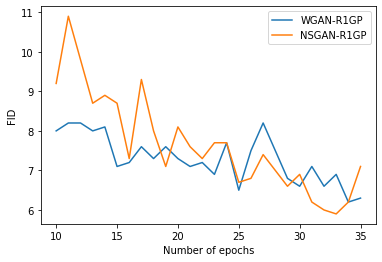

In [4]:
start_ep = 10
end_ep = min(len(all_fids_tr35b), len(all_fids_tr36b))
losscmp_xs = range(start_ep, end_ep)
sns.lineplot(x=losscmp_xs, y=all_fids_tr35b[start_ep:end_ep], label='WGAN-R1GP')
ax=sns.lineplot(x=losscmp_xs, y=all_fids_tr36b[start_ep:end_ep], label='NSGAN-R1GP')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('FID')

Text(0, 0.5, 'FID')

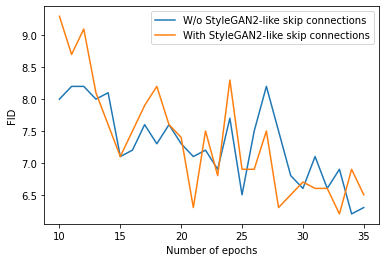

In [5]:
start_ep = 10
sns.lineplot(x=range(start_ep, len(all_fids_tr35b)), y=all_fids_tr35b[start_ep:], label='W/o StyleGAN2-like skip connections')
ax=sns.lineplot(x=range(start_ep, len(all_fids_tr38)), y=all_fids_tr38[start_ep:], label='With StyleGAN2-like skip connections')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('FID')

Text(0, 0.5, 'FID')

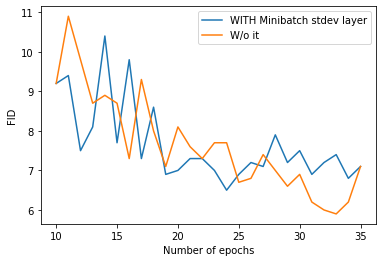

In [6]:
start_ep = 10
end_ep = min(len(all_fids_tr36b), len(all_fids_tr39))
minibatchstd_xs = range(start_ep, end_ep)
sns.lineplot(x=minibatchstd_xs, y=all_fids_tr39[start_ep:end_ep], label='WITH Minibatch stdev layer')
ax=sns.lineplot(x=minibatchstd_xs, y=all_fids_tr36b[start_ep:end_ep], label='W/o it')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('FID')

Text(0, 0.5, 'FID')

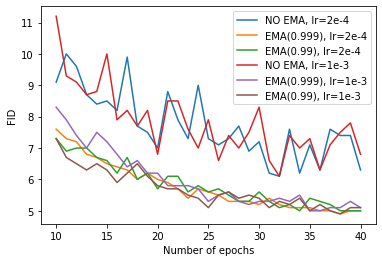

In [7]:
start_ep = 10
end_ep = min(len(all_fids_tr40b_no_ema), len(all_fids_tr40b_ema0999), len(all_fids_tr40b_ema099))
minibatchstd_xs = range(start_ep, end_ep)
sns.lineplot(x=minibatchstd_xs, y=all_fids_tr40b_no_ema[start_ep:end_ep], label='NO EMA, lr=2e-4')
sns.lineplot(x=minibatchstd_xs, y=all_fids_tr40b_ema0999[start_ep:end_ep], label='EMA(0.999), lr=2e-4')
ax=sns.lineplot(x=minibatchstd_xs, y=all_fids_tr40b_ema099[start_ep:end_ep], label='EMA(0.99), lr=2e-4')
sns.lineplot(x=minibatchstd_xs, y=all_fids_tr40b2_no_ema[start_ep:end_ep], label='NO EMA, lr=1e-3')
sns.lineplot(x=minibatchstd_xs, y=all_fids_tr40b2_ema0999[start_ep:end_ep], label='EMA(0.999), lr=1e-3')
ax=sns.lineplot(x=minibatchstd_xs, y=all_fids_tr40b2_ema099[start_ep:end_ep], label='EMA(0.99), lr=1e-3')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('FID')